LEO JEAN (LJ) PAGGEN

i6236337

# Data Analysis

# Clinic 2: Regress the price!

## DELIVERABLES (DEADLINE 10/March late night, wildcards possible)

Instructions for the deliverable: 

* Make sure that you include a proper amount/mix of comments, results and code.

* In the end, make sure that all cells are executed properly and everything you need to show is in your (execucted) notebook.

* You are asked to deliver **only your executed notebook file, .ipnyb** and nothing else. Enjoy!

* The second part of the assignment is purposefully left open-ended.  You will be allowed to build a linear model of your choice to better predict the price. 

* Honor code applies to these tasks. Only individual work should be submitted.

* Data science is a collaborative activity. While you may talk with others about the clinic, we ask that you **write your solutions individually**. If you do discuss the assignments with others please **include their names** below.

**Names of collaborators**: 

# 0. Introduction

In this clinic, we will go through the iterative process of specifying, fitting, and refining a model.  

In the first part of the assignment, we will guide you through some basic EDA, laying out the thought process that leads to certain modeling decisions.  We will then specify and fit more linear models, providing an example of the type of code we expect from you in the open-response.

The second part of the assignment is purposefully left open-ended.  You will be allowed to build a linear model of your choice to better predict the price. 

After this homework, you should feel comfortable with the following:

1. Working with a messy data set that requires a moderate amount of cleaning and wrangling
1. Using `sklearn` to build models
1. Using several different transformations on your data
1. Building a data pipeline using pandas
1. Using cross-validation for model selection

## Score breakdown

Question | Points
--- | ---
[Question 1a](#q1a) | 2
[Question 1b](#q1b) | 3
[Question 2](#q2) | 5
[Question 3](#q3) | 25
[Question 4](#q4) | 5
[Question 5](#q5) | 5
[Question 6](#q6) | 5
Total | 50

This score will be scaled down to 1 and that will be your final clinic score.

In [2]:
#necessary imports (edit as you see fit)
import numpy as np

import pandas as pd
from pandas.api.types import CategoricalDtype

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import linear_model as lm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

# Plot settings
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12

## 0.1 The Data

The datset consists of 2930 records for house prices. The data are real and stem from the Ames Assessor's Office. They were used in computing assessed values for individual residential properties sold in Ames, IA from 2006 to 2010. The data set has 23 nominal, 23 ordinal, 14 discrete, and 20 continuous variables (and 2 additional observation identifiers) --- 82 features in total.  An explanation of each variable can be found in the included `codebook.txt` file. **Some noise has been added to the actual sale price, so prices will not match official records or other versions of the dataset to be found online, so please don't try to cheat!**

The data are split into training and test sets with 2000 and 930 observations, respectively.  The test set provided here is for you to build your models. 

### 0.1.1 A little bit on the background on these house pricing datasets
In the United States, all property owners are required to pay property taxes, which are then used to fund public services including education, road maintenance, and sanitation. These property tax assessments are based on property values estimated using statistical models that consider multiple factors, such as real estate value and construction cost.

This system, however, is not without flaws. In late 2017, a lawsuit was filed against the office of Cook County Assessor Joseph Berrios for producing [“racially discriminatory assessments and taxes."](https://www.chicagotribune.com/politics/ct-cook-county-board-assessor-berrios-met-20170718-story.html) The lawsuit included claims that the assessor’s office undervalued high-priced homes and overvalued low-priced homes, creating a visible divide along racial lines: Wealthy homeowners, who were typically white, [paid less in property taxes](https://www.clccrul.org/bpnc-v-berrios-facts?rq=berrios), whereas [working-class, non-white homeowners paid more](https://www.chicagotribune.com/news/breaking/ct-cook-county-assessor-berrios-sued-met-20171214-story.html).

The Chicago Tribune's four-part series, ["The Tax Divide"](https://www.chicagotribune.com/investigations/ct-tax-divide-investigation-20180425-storygallery.html), delves into how this was uncovered: After "compiling and analyzing more than 100 million property tax records from the years 2003 through 2015, along with thousands of pages of documents, then vetting the findings with top experts in the field," they discovered that "residential assessments [had] been so far off the mark for so many years." You can read more about their investigation [here](https://apps.chicagotribune.com/news/watchdog/cook-county-property-tax-divide/assessments.html).

Additionally, the discrimination described in the lawsuit is built on a much deeper history - including the practice of redlining in Chicago. Though this is by no means a comprehensive history, Merriam-Webster defines redlining as the "withholdding of home-loan funds or insurance from neighborhoods considered poor economic risks." The neighborhoods in this category, however, were typically comprised of Black communities; redlining, then, systemically prevented Black residents from moving into other neighborhoods and improving their current homes by denying them the financial assistance that white residents were afforded. Though the Fair Housing Act of 1968 outlawed redlining, its [impacts](https://www.washingtonpost.com/news/wonk/wp/2018/03/28/redlining-was-banned-50-years-ago-its-still-hurting-minorities-today/) and [practices](https://www.chicagotribune.com/business/ct-biz-modern-day-redlining-20180215-story.html) are still present today.

This context is vital to understanding how different datasets might be created. This introduction aims to address how legacies of racial discrimination practices can be encoded within data, as well as consider how they might influence modeling choices.

In [3]:
training_data = pd.read_csv("ames_train.csv")
test_data = pd.read_csv("ames_test.csv")

As a good sanity check, we should at least verify that the data shape matches the description.

In [4]:
# 1977 observations and 82 features in training data
assert training_data.shape == (1977, 82)
# 799 observations and 82 features in test data
assert test_data.shape == (799, 82)
# Every column in the test data should be in the training data
assert len(np.intersect1d(test_data.columns.values, 
                          training_data.columns.values)) == 82

The next order of business is getting a feel for the variables in our data.  The Ames data set contains information that typical homebuyers would want to know.  A more detailed description of each variable is included in `codebook.txt`.  **You should take some time to familiarize yourself with the codebook before moving forward.** If you find any issues or inconsistencies in the codebook, please report them to us!

In [5]:
training_data.columns.values

array(['Order', 'PID', 'MS_SubClass', 'MS_Zoning', 'Lot_Frontage',
       'Lot_Area', 'Street', 'Alley', 'Lot_Shape', 'Land_Contour',
       'Utilities', 'Lot_Config', 'Land_Slope', 'Neighborhood',
       'Condition_1', 'Condition_2', 'Bldg_Type', 'House_Style',
       'Overall_Qual', 'Overall_Cond', 'Year_Built', 'Year_Remod/Add',
       'Roof_Style', 'Roof_Matl', 'Exterior_1st', 'Exterior_2nd',
       'Mas_Vnr_Type', 'Mas_Vnr_Area', 'Exter_Qual', 'Exter_Cond',
       'Foundation', 'Bsmt_Qual', 'Bsmt_Cond', 'Bsmt_Exposure',
       'BsmtFin_Type_1', 'BsmtFin_SF_1', 'BsmtFin_Type_2', 'BsmtFin_SF_2',
       'Bsmt_Unf_SF', 'Total_Bsmt_SF', 'Heating', 'Heating_QC',
       'Central_Air', 'Electrical', '1st_Flr_SF', '2nd_Flr_SF',
       'Low_Qual_Fin_SF', 'Gr_Liv_Area', 'Bsmt_Full_Bath',
       'Bsmt_Half_Bath', 'Full_Bath', 'Half_Bath', 'Bedroom_AbvGr',
       'Kitchen_AbvGr', 'Kitchen_Qual', 'TotRms_AbvGrd', 'Functional',
       'Fireplaces', 'Fireplace_Qu', 'Garage_Type', 'Garage_Yr_Blt',

# 1. Guided Modeling

In the first part of the assignment, we will take you step-by-step through one cycle of the modeling process.  Along the way, we will provide commentary to give you a sense of the thought process that goes into building a model. We give examples on most of the common cases we have explored (EDA, missing values, feature engineering etc.), but feel free to extend this analyses for your final model.

## 1.1 EDA
Naturally, the first thing we want to do is get a feel for our data.  In this section, we will make a series of exploratory visualizations.  The plots we ask you to reproduce here are far from exhaustive. **When you build your own model in the second part of this assignment, you will want to delve deeper into the data.**

Note that we will perform EDA on the **training data** so that information from the test data does not influence our modeling decisions.

### 1.1.1 Sale Price
We begin by examining a [raincloud plot](https://www.kaggle.com/code/carlmcbrideellis/box-strip-violin-raincloud-plot) (yet another name for a combination of a KDE, a boxplot, and a boxplot all-in-one) of our target variable `SalePrice`.  At the same time, we also take a look at some descriptive statistics of this variable.

/Applications/anaconda3/envs/datasci/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Applications/anaconda3/envs/datasci/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Applications/anaconda3/envs/datasci/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


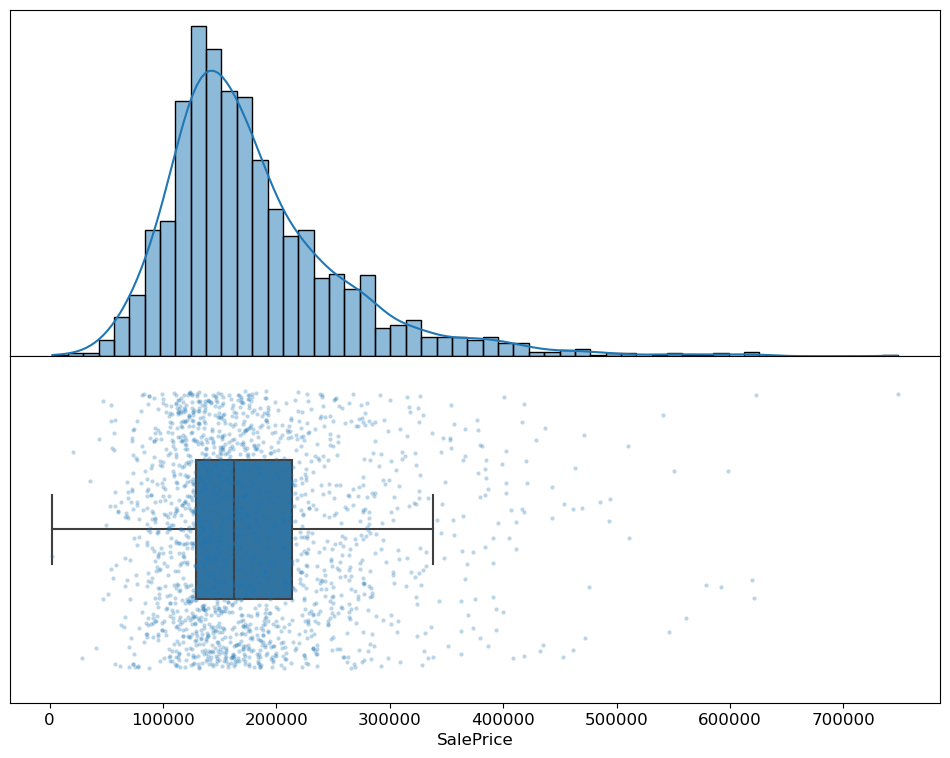

In [6]:
fig, axs = plt.subplots(nrows=2)

sns.histplot(
    training_data['SalePrice'],
    kde=True,
    ax=axs[0]
)

sns.stripplot(
    training_data['SalePrice'], 
    orient='h',
    jitter=0.4, 
    size=3,
    ax=axs[1],
    alpha=0.3
)
sns.boxplot(
    training_data['SalePrice'],
    orient='h',
    width=0.4, 
    ax=axs[1],
    showfliers=False,
)

# Align axes
spacer = np.max(training_data['SalePrice']) * 0.05
xmin = np.min(training_data['SalePrice']) - spacer
xmax = np.max(training_data['SalePrice']) + spacer
axs[0].set_xlim((xmin, xmax))
axs[1].set_xlim((xmin, xmax))

# Remove some axis text
axs[0].xaxis.set_visible(False)
axs[0].yaxis.set_visible(False)
axs[1].yaxis.set_visible(False)

# Put the two plots together
plt.subplots_adjust(hspace=0)

# Adjust boxplot fill to be white
axs[1].set_facecolor('white')

In [7]:
#Summary statistics for price
training_data['SalePrice'].describe()

count      1977.000000
mean     181000.225089
std       81574.637125
min        2489.000000
25%      128800.000000
50%      162500.000000
75%      214000.000000
max      747800.000000
Name: SalePrice, dtype: float64

To check your understanding of the graph and summary statistics above, answer the following `True` or `False` questions:

1. The distribution of `SalePrice` in the training set is left-skew.
1. The mean of `SalePrice` in the training set is greater than the median.
1. 75% of the houses in the training set sold for less than \$214,000.00.

If you have trouble answering the questions above, discuss them in class with each other and confirm with a TA

### 1.1.2 SalePrice vs Gr_Liv_Area

Next, we examine `SalePrice` vs `Gr_Liv_Area`.  Now it's not entirely obvious what `Gr_Liv_Area` should be, so we'll need to consult `codebook.txt`.  We find:

```
Gr Liv Area (Continuous): Above grade (ground) living area square feet
```

Ok, so this variable represents the square footage of the house excluding anything built underground.  Some additional research (into real estate conventions) reveals that this value also excludes the garage space.

/Applications/anaconda3/envs/datasci/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Applications/anaconda3/envs/datasci/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


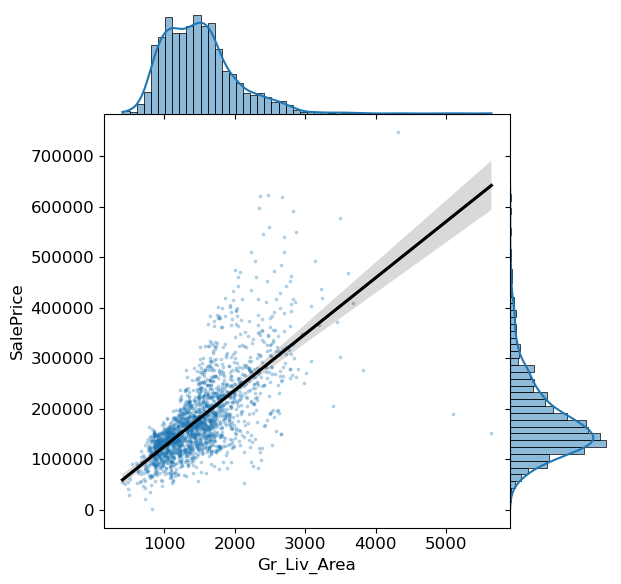

In [8]:
sns.jointplot(
    x='Gr_Liv_Area',
    y='SalePrice',
    data=training_data,
#    stat_func=None,
    kind="reg",
    ratio=4,
    space=0,
    scatter_kws={
        's': 3,
        'alpha': 0.25
    },
    line_kws={
        'color': 'black'
    }
)

We notice that there is a plausible linear relationship between house size and sale price, but the spread is wider at larger sale prices and above grade living areas.  There seem to be two particularly suspicious houses above 5000 square feet.

What do we do when we have outliers? Let's check them properly!

What are the Parcel Indentification Numbers for the two houses with `Gr_Liv_Area` greater than 5000 sqft? That's something that can be answered just through Pandas

In [9]:
# Hint: You can answer this question purely through pandas
# q2house1 and q2house2 should be integers
q2house1 = training_data["PID"][training_data["Gr_Liv_Area"] > 5000].iloc[0].item()
q2house2 = training_data["PID"][training_data["Gr_Liv_Area"] > 5000].iloc[1].item()

pd.set_option('mode.chained_assignment', None) 
q2house1,q2house2

(908154235, 908154195)

The codebook actually tells us how to manually inspect the houses using an online database called Beacon. These two houses are true outliers in this data set.  They were partial sales that were priced much under market value.  We will remove them in the guided model, but perhaps you will want to address them differently in your own model.  To make sure you know how to view the online database, please answer the following question:

What are the gross values of the two houses with `Gr_Liv_Area` greater than 5000 as of 2022?  You will find this under the section titled "Valuation (Ames)".  Your answers should be integers.

A note to use the Beacon database: You can use the PID as in the data, but you need to prefix 0. So, if the PID of a house is 999235239, you can find it in the database as 0999235239.

In [10]:
q3house1 = 2,310,300
q3house2 = 1,747,900

Below we write a function `remove_outliers` that removes outliers from a data set based off a threshold value of a variable. For example, `remove_outliers(training_data, 'Gr_Liv_Area', upper=5000)` should return a data frame with only observations that satisfy `Gr_Liv_Area` less than or equal to 5000.

In [11]:
def remove_outliers(data, variable, lower=-np.inf, upper=np.inf):
    """
    Input:
      data (data frame): the table to be filtered
      variable (string): the column with numerical outliers
      lower (numeric): observations with values lower than this will be removed
      upper (numeric): observations with values higher than this will be removed
    
    Output:
      a winsorized data frame with outliers removed
    """
    return data.loc[(data[variable] > lower) & (data[variable] < upper)]


training_data = remove_outliers(training_data, 'Gr_Liv_Area', upper=5000)

In [12]:
#making sure the two observations were removed
assert training_data.shape[0] == 1975

### 1.1.3 Neighborhood vs Sale Price

Next we explore this relationship.

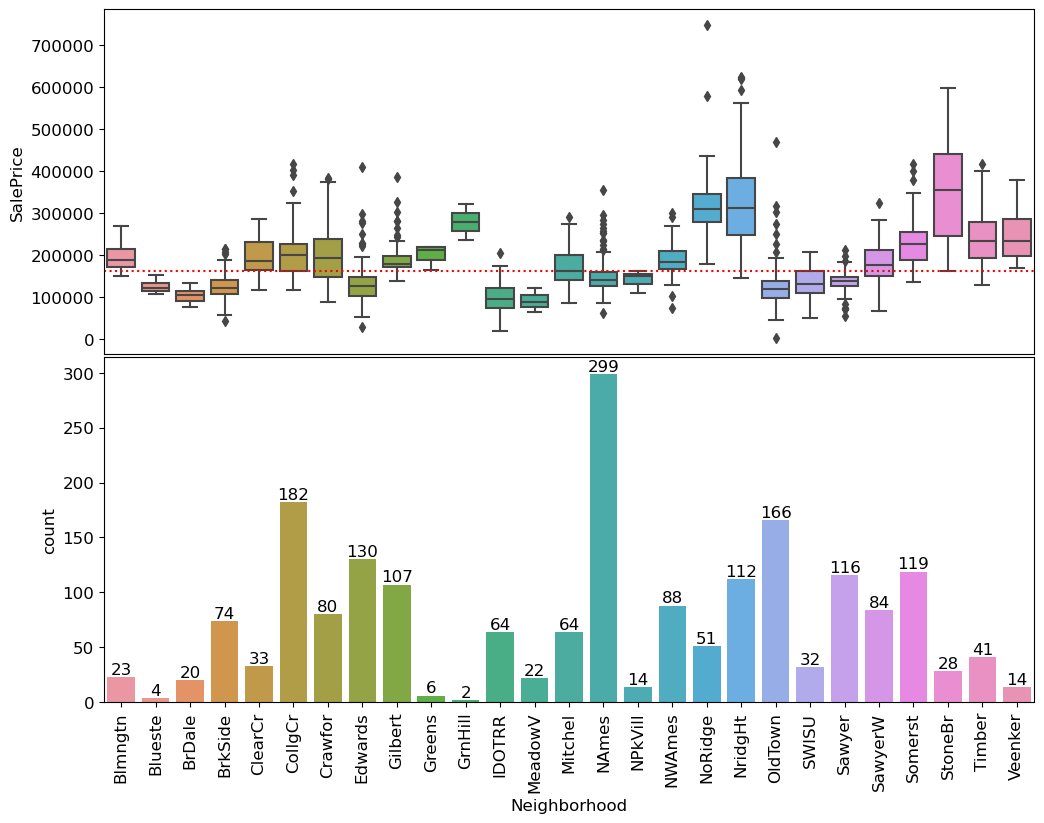

In [13]:
fig, axs = plt.subplots(nrows=2)

sns.boxplot(
    x='Neighborhood',
    y='SalePrice',
    data=training_data.sort_values('Neighborhood'),
    ax=axs[0]
)

sns.countplot(
    x='Neighborhood',
    data=training_data.sort_values('Neighborhood'),
    ax=axs[1]
)

# Draw median price
axs[0].axhline(
    y=training_data['SalePrice'].median(), 
    color='red',
    linestyle='dotted'
)

# Label the bars with counts
for patch in axs[1].patches:
    x = patch.get_bbox().get_points()[:, 0]
    y = patch.get_bbox().get_points()[1, 1]
    axs[1].annotate(f'{int(y)}', (x.mean(), y), ha='center', va='bottom')
    
# Format x-axes
axs[1].set_xticklabels(axs[1].xaxis.get_majorticklabels(), rotation=90)
axs[0].xaxis.set_visible(False)

# Narrow the gap between the plots
plt.subplots_adjust(hspace=0.01)

From the plot above, it becomes clear that there is quite some variation in prices across neighborhoods.  Moreover, the amount of data available is not uniformly distributed among neighborhoods.  North Ames, for example, comprises almost 15% of the training data while Green Hill has a scant 2 observations in this data set.

One way we can deal with the lack of data from some neighborhoods is to create a new feature that bins neighborhoods together.  Let's dichotomize our neighborhoods in a very crude way: we'll take the top 3 neighborhoods measured by median `SalePrice` and identify them as "rich neighborhoods"; the other neighborhoods are not marked.

Now we write a function that returns list of the top-$n$ most pricey neighborhoods as measured by our choice of aggregating function.  For example, in the setup above, we would want to call `find_rich_neighborhoods(training_data, 3)` to find the top 3 neighborhoods measured by median `SalePrice`.

In [14]:
def find_rich_neighborhoods(data, n=3):
    """
    Input:
      data (data frame): should contain at least a string-valued Neighborhood
        and a numeric SalePrice column
      n (int): the number of top values desired
    
    Output:
      a list of the top n richest neighborhoods as measured by the metric function
    """
    neighborhoods = data.groupby("Neighborhood")["SalePrice"].median().sort_values(ascending=False).iloc[:n].index.values.tolist()
    #deprecated -->
    #neighborhoods = data.groupby("Neighborhood").agg(metric).sort_values(by=["SalePrice"],ascending=False).iloc[:n].index.values.tolist()
    return neighborhoods

rich_neighborhoods = find_rich_neighborhoods(training_data, 3)
rich_neighborhoods

['StoneBr', 'NridgHt', 'NoRidge']

In [15]:
# Check to see if the n argument works
assert len(find_rich_neighborhoods(training_data, 5)) == 5
assert isinstance(rich_neighborhoods, list)
# Check to see if the list contains only strings
assert all([isinstance(neighborhood, str) for neighborhood in rich_neighborhoods])

## 1.2 Missing Data

Let's see if our data set has any missing values.  Create a Series object containing the counts of missing values in each of the columns of our data set sorted from greatest to least.  The Series should be indexed by the variable names. For example, `missing_counts['Fireplace_Qu']` should return 959.

In [16]:
missing_counts = len(training_data.index) - training_data.count()

missing_counts['Fireplace_Qu']

959

In [17]:
# Make sure your answer is a Series
assert isinstance(missing_counts, pd.Series)
# Make sure all columns are represented
assert missing_counts.size == 82
# Make sure your index values match column names
assert set(missing_counts.index.values) == set(training_data.columns.values)

It turns out that if we look at the codebook carefully, some of these "missing values" aren't missing at all! The Assessor's Office just used `NA` to denote a special value or that the information was truly not applicable for one reason or another.  One such example is the `Fireplace_Qu` variable.
```
FireplaceQu (Ordinal): Fireplace quality

       Ex	Excellent - Exceptional Masonry Fireplace
       Gd	Good - Masonry Fireplace in main level
       TA	Average - Prefabricated Fireplace in main living area or Masonry Fireplace inbasement
       Fa	Fair - Prefabricated Fireplace in basement
       Po	Poor - Ben Franklin Stove
       NA	No Fireplace
```

An `NA` here actually means that the house had no fireplace to rate.  Let's fix this in our data set.  Write a function that replaces the missing values in `Fireplace_Qu` with `'No Fireplace'`.  In addition, it should replace each abbreviated condition with its full word.  For example, `'TA'` should be changed to `'Average'`.  Hint: the [DataFrame.replace](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.replace.html) method may be useful here.


In [18]:
def fix_fireplace_qu(data):
    """
    Input:
      data (data frame): a data frame containing a Fireplace_Qu column.  Its values
                         should be limited to those found in the codebook
    Output:
      data frame identical to the input except with a refactored Fireplace_Qu column
    """
    dictz = {
        "Ex":"Excellent",
        "Gd":"Good",
        "TA":"Average",
        "Fa": "Fair",
        "Po": "Poor",
    }
    data['Fireplace_Qu'] = data['Fireplace_Qu'].replace(dictz)
    data['Fireplace_Qu'] = data['Fireplace_Qu'].fillna(value="No Fireplace")
    return data

training_data = fix_fireplace_qu(training_data)

training_data['Fireplace_Qu']

0               Good
1       No Fireplace
2       No Fireplace
3            Average
4            Average
            ...     
1972            Good
1973    No Fireplace
1974            Good
1975    No Fireplace
1976            Good
Name: Fireplace_Qu, Length: 1975, dtype: object

In [19]:
# Make sure you've replaced all the missing values with 'No Fireplace'
assert sum(training_data['Fireplace_Qu'] == 'No Fireplace') == 959

It turns out that simply fixing these missing values isn't sufficient for using `Fireplace_Qu` in our model.  Since `Fireplace_Qu` is a categorical/nominal variable, we will have to one-hot-encode the data.  Notice in the example code below that we have to pre-specify the categories.  Why? Imagine what would happen if we automatically generated the categories only from the training data.  What would happen if the testing data contained a category not found in the training set?  For more information on categorical data in pandas, refer to this [link](https://pandas-docs.github.io/pandas-docs-travis/categorical.html).  **Note that `get_dummies` removes the original column.**

In [20]:
def ohe_fireplace_qu(data):
    """
    One-hot-encodes fireplace quality.  New columns are of the form fpq_QUALITY
    """
    cats = [
        'Excellent',
        'Good',
        'Average',
        'Fair',
        'Poor',
        'No Fireplace'
    ]

    cat_type = CategoricalDtype(categories=cats)

    data['Fireplace_Qu'] = data['Fireplace_Qu'].astype(cat_type)
    data = pd.get_dummies(data,
                          prefix='fpq',
                          columns=['Fireplace_Qu'],
                          drop_first=True)

    return data

In [21]:
training_data = ohe_fireplace_qu(training_data)
training_data.filter(regex='fpq').head(10)

fpq_Good  fpq_Average  fpq_Fair  fpq_Poor  fpq_No Fireplace
0      True        False     False     False             False
1     False        False     False     False              True
2     False        False     False     False              True
3     False         True     False     False             False
4     False         True     False     False             False
5      True        False     False     False             False
6     False        False     False     False              True
7     False         True     False     False             False
8     False        False     False     False              True
9      True        False     False     False             False

## 1.3 Feature Engineering

In this section we will create a new feature out of existing ones through a simple data transformation.  When you move on to create your own model, you may want to try out more complex transformations.

### 1.3.1 Bathrooms

We will create a groundbreaking new feature. Due to recent advances in Universal WC Enumeration Theory, we now know that Total Bathrooms can be calculated as:

$$ TotalBathrooms=(BsmtFullBath + FullBath) + \dfrac{1}{2}(BsmtHalfBath + HalfBath)$$

The actual proof is beyond the scope of this class, but we will use the result in our model.

We write a function `add_total_bathrooms(data)` that returns the input data frame with a new column called `total_bathrooms` as calculated above. Note that we Treat missing values as 0s and we make extensive use of vectorized code.

In [22]:
def add_total_bathrooms(data):
    """
    Input:
      data (data frame): a data frame containing at least 4 numeric columns 
            Bsmt_Full_Bath, Full_Bath, Bsmt_Half_Bath, and Half_Bath
    Output:
      data frame identical to the input with the addition of a total_bathrooms column
    """
    a = data.loc[:,"Bsmt_Full_Bath"].fillna(value=0)
    b = data.loc[:,"Full_Bath"].fillna(value=0)
    c = 0.5*data.loc[:,"Bsmt_Half_Bath"].fillna(value=0)
    d = 0.5*data.loc[:,"Half_Bath"].fillna(value=0)
    data["total_bathrooms"] = a+b+c+d
    return data

training_data = add_total_bathrooms(training_data)

training_data.head()

Order        PID  MS_SubClass MS_Zoning  Lot_Frontage  Lot_Area Street  \
0      1  526301100           20        RL         141.0     31770   Pave   
1      2  526350040           20        RH          80.0     11622   Pave   
2      3  526351010           20        RL          81.0     14267   Pave   
3      4  526353030           20        RL          93.0     11160   Pave   
4      5  527105010           60        RL          74.0     13830   Pave   

  Alley Lot_Shape Land_Contour  ... Yr_Sold Sale_Type Sale_Condition  \
0   NaN       IR1          Lvl  ...    2010        WD         Normal   
1   NaN       Reg          Lvl  ...    2010        WD         Normal   
2   NaN       IR1          Lvl  ...    2010        WD         Normal   
3   NaN       Reg          Lvl  ...    2010        WD         Normal   
4   NaN       IR1          Lvl  ...    2010        WD         Normal   

  SalePrice fpq_Good fpq_Average fpq_Fair fpq_Poor  fpq_No Fireplace  \
0    204900     True       False    False    False             False   
1     95300    False       False    False    False              True   
2    181900    False       False    False    False              True   
3    254100    False        True    False    False             False   
4    199700    False        True    False    False             False   

   total_bathrooms  
0              2.0  
1              1.0  
2              1.5  
3              3.5  
4              2.5  

[5 rows x 87 columns]

In [23]:
# Check that missing values are dealt with
assert ~training_data['total_bathrooms'].isnull().any()
# Check that the values are as expected
assert training_data['total_bathrooms'].sum() == 4367.5

### 1.3.2 Rich Neighborhoods

From before, we have a list of neighborhoods we've deemed as richer than others.  Let's use that information to make a new variable `in_rich_neighborhood`. We write a function `add_rich_neighborhood` that adds an indicator variable which takes on the value 1 if the house is part of `rich_neighborhoods` and the value 0 otherwise.

In [24]:
def add_in_rich_neighborhood(data, neighborhoods):
    """
    Input:
      data (data frame): a data frame containing a 'Neighborhood' column with values
        found in the codebook
      neighborhoods (list of strings): strings should be the names of neighborhoods
        pre-identified as rich
    Output:
      data frame identical to the input with the addition of a binary
      in_rich_neighborhood column
    """
    data["in_rich_neighborhood"] = 0
    mask = data["Neighborhood"].isin(neighborhoods)
    data.loc[mask,"in_rich_neighborhood"] = 1
    return data

rich_neighborhoods = find_rich_neighborhoods(training_data, 3)
training_data = add_in_rich_neighborhood(training_data, rich_neighborhoods)

training_data.head()

Order        PID  MS_SubClass MS_Zoning  Lot_Frontage  Lot_Area Street  \
0      1  526301100           20        RL         141.0     31770   Pave   
1      2  526350040           20        RH          80.0     11622   Pave   
2      3  526351010           20        RL          81.0     14267   Pave   
3      4  526353030           20        RL          93.0     11160   Pave   
4      5  527105010           60        RL          74.0     13830   Pave   

  Alley Lot_Shape Land_Contour  ... Sale_Type Sale_Condition SalePrice  \
0   NaN       IR1          Lvl  ...        WD         Normal    204900   
1   NaN       Reg          Lvl  ...        WD         Normal     95300   
2   NaN       IR1          Lvl  ...        WD         Normal    181900   
3   NaN       Reg          Lvl  ...        WD         Normal    254100   
4   NaN       IR1          Lvl  ...        WD         Normal    199700   

  fpq_Good fpq_Average fpq_Fair fpq_Poor fpq_No Fireplace  total_bathrooms  \
0     True       False    False    False            False              2.0   
1    False       False    False    False             True              1.0   
2    False       False    False    False             True              1.5   
3    False        True    False    False            False              3.5   
4    False        True    False    False            False              2.5   

   in_rich_neighborhood  
0                     0  
1                     0  
2                     0  
3                     0  
4                     0  

[5 rows x 88 columns]

In [25]:
# Check to see if you have identified the correct number of rich neighborhoods
assert sum(training_data['in_rich_neighborhood']) == 191
# Check to see if you've introduced any missing values
assert sum(training_data['in_rich_neighborhood'].isnull()) == 0

# 2. Modeling

We've finally gotten to a point where we can specify a simple model.  But first, we need to create perform a test-train split of our data.  We begin by loading a fresh copy of the data in at this point just in case our code above produced any undesired side-effects.  At this point, we will begin to treat `ames_train.csv` as our complete data set.  We will use `train_test_split` from `sklearn` to split the data into `test` and `train` sets.

Remember: The reason we have to do a train-test split on `ames_train.csv` here is because we want to evaluate how well our model might perform on future data (`ames_test.csv`), but that data set does not have `SalePrice` in it!

In [26]:
# Load a fresh copy of the data
full_data = pd.read_csv("ames_train.csv")

# This makes the train-test split in this section reproducible across different runs 
# of the notebook.  You do not need this line to run train_test_split in general
np.random.seed(1337) 

# Split the data 
train, test = train_test_split(full_data, test_size=0.2)

In [27]:
# Something has gone awry in the cell above if these do not pass
assert test.shape == (396, 82)
assert train.shape == (1581, 82)
assert train.loc[887, 'PID'] == 902402260

## 2.1 Reusable Pipeline

Throughout this assignment, you should notice that your data flows through a single processing pipeline several times.  From a software engineering perspective, this should be sufficient motivation to abstract parts of our code into reusable functions/methods.  We will now encapsulate our entire pipeline into a single function `process_data_gm`.  gm is shorthand for "guided model".

In [28]:
def select_columns(data, *columns):
    return data.reindex(columns = columns)
    #deprecated:
    #return data.loc[:, columns]

def process_data_gm1(data):
    # Clean Data
    data = remove_outliers(data, 'Gr_Liv_Area', upper=5000)
    data = fix_fireplace_qu(data)

    # Transform Data
    data = add_total_bathrooms(data)
    data = add_in_rich_neighborhood(data, rich_neighborhoods)
    data = select_columns(data, 
                          'SalePrice', 
                          'Gr_Liv_Area', 
                          'total_bathrooms',
                          'Fireplace_Qu',
                          'in_rich_neighborhood'
                         )
    data = ohe_fireplace_qu(data)

    # Return predictors and response variables separately
    X = data.drop(['SalePrice'], axis = 1)
    y = data['SalePrice']

    return X, y

An alternative way of writing the same code above explicitly allows us to think about our data flowing through a [pipeline](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.pipe.html) where the output of one function is the input of the next.  Carefully thought out function names make the code self-documenting: you can just read off the intended high-level processing steps from top to bottom.

You are not required to use this style of coding.  We just wanted to point out that it exists.

In [29]:
def process_data_gm1(data):

    data = (
        data
        # Clean Data
        .pipe(remove_outliers, 'Gr_Liv_Area', upper=5000)
        .pipe(fix_fireplace_qu)
        
        # Transform data
        .pipe(add_total_bathrooms)
        .pipe(add_in_rich_neighborhood, rich_neighborhoods)
        .pipe(select_columns, 
              'SalePrice',           
              'Gr_Liv_Area',            
              'total_bathrooms',             
              'Fireplace_Qu',            
              'in_rich_neighborhood'
             )
        .pipe(ohe_fireplace_qu)
    ) 
    
    # Return predictors and response variables separately
    X = data.drop(['SalePrice'], axis = 1)
    y = data['SalePrice']
    
    return X, y

## 2.2 Fitting our first model

We are finally going to fit a model (yay!). This part is slightly unceremonious since we did much of the heavy lifting in the previous sections.  The model we will fit can be written as follows (with the caveat that one of the fireplace qualities is actually removed to avoid collinearity):

$$\begin{align} SalePrice = &\theta_0 + \theta_1 \times GrLivArea + \theta_2 \times TotalBathrooms \\
&+ \theta_3 \times InRichNeighborhood + \sum_{quality \in FireplaceQuality} \theta_{quality} \times Quality
\end{align}$$

#### Question 1a <a name="q1a"></a>
Remove the commenting and fill in the ellipses `...` below with `X_train`, `y_train`, `X_test`, or `y_test`.

In [30]:
X_train, y_train = process_data_gm1(train)
X_test, y_test = process_data_gm1(test)
guidedmodel1 = lm.LinearRegression(fit_intercept=True)

guidedmodel1.fit(X_train, y_train)
y_fitted = guidedmodel1.predict(X_train)
y_predicted = guidedmodel1.predict(X_test)

In [31]:
print(y_fitted.mean())
print(y_predicted.mean())

182110.70804306524
177830.36603129754


In [32]:
assert 181100 <= y_fitted.mean() <= 183400
assert 177600 <= y_predicted.mean() <= 177900

In this assignment, we will use Root-Mean-Square Error (RMSE) to measure the quality of our models.  As a reminder, this quantity is defined as:

$RMSE = \sqrt{\dfrac{\sum_{\text{houses in test set}}(\text{actual price of house} - \text{predicted price of house})^2}{\text{# of houses in test set}}}$

#### Question 1b <a name="q1b"></a>

Write a function `rmse` that calculates the RMSE of a model.  Again, make sure you are taking advantage of vectorized code.  This can be solved without any iteration.

In [33]:
def rmse(actual, predicted):
    """
    Calculates RMSE from actual and predicted values
    Input:
      actual (1D array-like): vector of actual values
      predicted (1D array-like): vector of predicted/fitted values
    Output:
      a float, the root-mean square error
    """

    rmse = np.sqrt(np.mean((np.array(actual) - np.array(predicted)) ** 2))

    return rmse

rmse(y_test, y_predicted)

45006.19615694448

In [34]:
assert 44000 <= rmse(y_test, y_predicted) <= 46000

## 2.3 Checking our model: Residual Plots

Recall from the lectures, that one way of diagnosing a model is through a residual plot.  Here we plot the actual sale prices against the residuals of the model.  Ideally, we would see a horizontal line of points at 0 (perfect prediction!).  The next best thing would be a homogenous set of points centered at 0.  But alas, our simple model is probably too simple.  We notice that we are really underfitting the more expensive homes in the test set.  In fact, it looks like our model tends to underprice the more expensive homes!  You will probably want to address this in your own work.

Text(0, 0.5, 'Residuals (Actual Price - Predicted Price)')

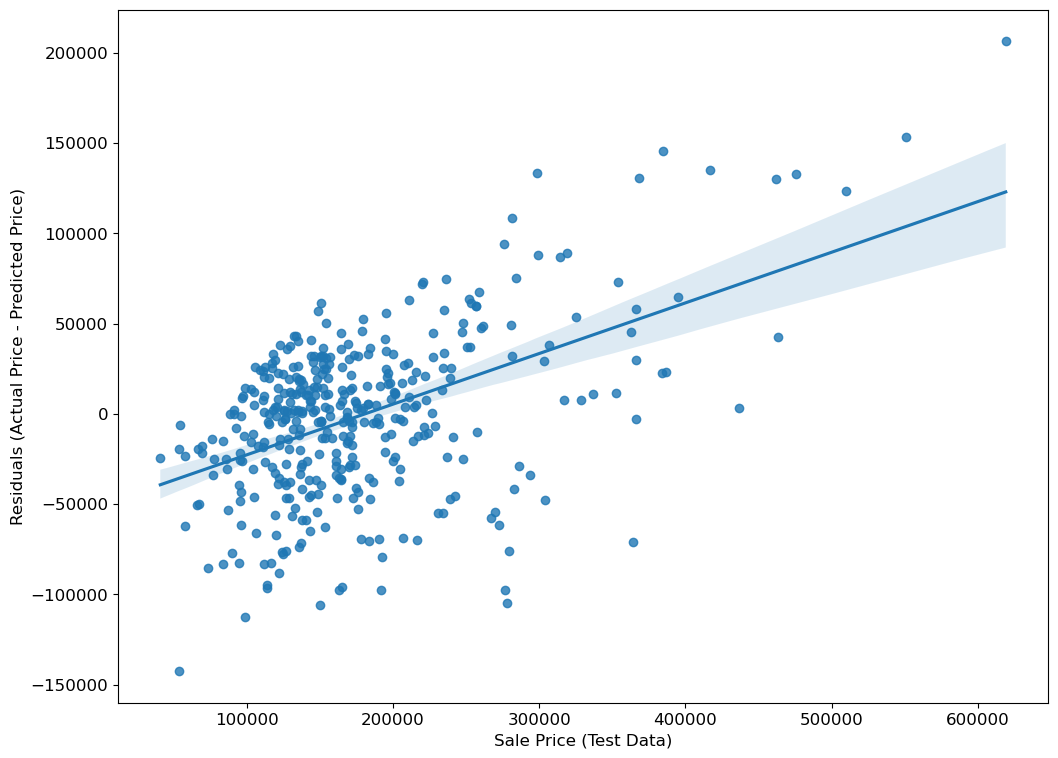

In [35]:
gm1_residuals = y_test - y_predicted
ax = sns.regplot(x=y_test, y=gm1_residuals)
ax.set_xlabel('Sale Price (Test Data)')
ax.set_ylabel('Residuals (Actual Price - Predicted Price)')

## 2.4 Regularizing our model

Ok, so let's make our modeling a little more fancy by regularizing the coefficients.  This second model will use the Lasso, but you are free to use Ridge or other in your work.  First, we need to add a step to our pre-processing.  In order for regularization to be fair to all the variables in our model, we need to standardize our predictor columns (otherwise it would unfairly penalize variables with inherently small values).

#### Question 2 <a name="q2"></a>

Write a function that standardizes the columns of a data frame containing only numeric columns.  Be sure to make use of vectorization.

In [36]:
def standardize_columns(data):
    '''
    Input:
      data (data frame): contains only numeric columns
    Output:
      data frame, the same data, except each column is standardized 
      to have 0-mean and unit variance
    '''
    standardized_data = (data - np.mean(data)) / np.std(data) # z score

    return standardized_data

In [37]:
test_standardize_df = standardize_columns(training_data[['SalePrice', 'Gr_Liv_Area']])
# Make sure the mean is correct
assert -0.001 < test_standardize_df.mean().sum() < 0.001
# Make sure the standard deviation is correct
assert 1.9 < test_standardize_df.std().sum() < 2.1

test_standardize_df

/Applications/anaconda3/envs/datasci/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


AssertionError: 

We'll now use this function to describe our new processing for the regularized model.

In [38]:
def process_data_gm2(data):

    data = (
        data
        # Clean Data
        .pipe(remove_outliers, 'Gr_Liv_Area', upper=5000)
        .pipe(fix_fireplace_qu)

        # Transform data
        .pipe(add_total_bathrooms)
        .pipe(add_in_rich_neighborhood, rich_neighborhoods)
        .pipe(select_columns, 
              'SalePrice',           
              'Gr_Liv_Area',            
              'total_bathrooms',             
              'Fireplace_Qu',            
              'in_rich_neighborhood'
             )
        .pipe(ohe_fireplace_qu)
    )

    # Return predictor and response variables separately
    X = standardize_columns(data).drop(['SalePrice'], axis = 1)
    y = data['SalePrice']

    return X, y

It may be instructive to see the cross-validation procedure explicitly once.  You should be able to understand what each part of the code is doing below, but we do not expect you to use this code for your own model (use [LassoCV](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html) instead).

In [39]:
# Process our data
X_train, y_train = process_data_gm2(train)
X_test, y_test = process_data_gm2(test)

# Specify our model
guidedmodel2 = lm.Lasso(copy_X=True)

# Specify CV method and alpha grid
five_fold_cv = KFold(n_splits = 5)
alphas = np.arange(0.1, 200.1, .1)
rmses = np.zeros(len(alphas))

# Grid search over alphas
for i, alpha in enumerate(alphas):
    guidedmodel2.set_params(alpha=alpha)
    model_rmse = 0
    
    # Fit each fold using the other four as training data
    for train_index, test_index in five_fold_cv.split(X_train):
        X_fold_train = X_train.iloc[train_index]
        y_fold_train = y_train.iloc[train_index]
        X_fold_test = X_train.iloc[test_index]
        y_fold_test = y_train.iloc[test_index]
        
        guidedmodel2.fit(X_fold_train, y_fold_train)
        y_fold_predicted = guidedmodel2.predict(X_fold_test)
        model_rmse += rmse(y_fold_test, y_fold_predicted)
    
    # Average RMSE over the five folds for alpha_i
    rmses[i] = model_rmse / 5

optimal_alpha = alphas[rmses == np.min(rmses)]
guidedmodel2.set_params(alpha=optimal_alpha[0]) # notice i did replace something here, Sven (from the class too) figured out the issue, you used an array[float] instead of using a float
guidedmodel2.fit(X_train, y_train)
y_predicted = guidedmodel2.predict(X_test)

print(f'The validation RMSE for this model with '
      f'alpha={float(optimal_alpha)} is {rmse(y_test, y_predicted)}.')

/Applications/anaconda3/envs/datasci/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Applications/anaconda3/envs/datasci/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


The validation RMSE for this model with alpha=69.1 is 274186743.6485487.


/var/folders/28/nqw3v6ld39g_jrhl3y66nq2w0000gn/T/ipykernel_10748/2758178381.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  f'alpha={float(optimal_alpha)} is {rmse(y_test, y_predicted)}.')


### 2.4.1 Lasso Path

Let's take a look at how RMSE varied across different choices of the regularization hyperparameter ($\lambda$ in lecture, `alpha` in `sklearn`).  This is often called the Lasso or Regularization Path.  The dashed red line marks the alpha that minimizes RMSE.

Text(0, 0.5, 'RMSE')

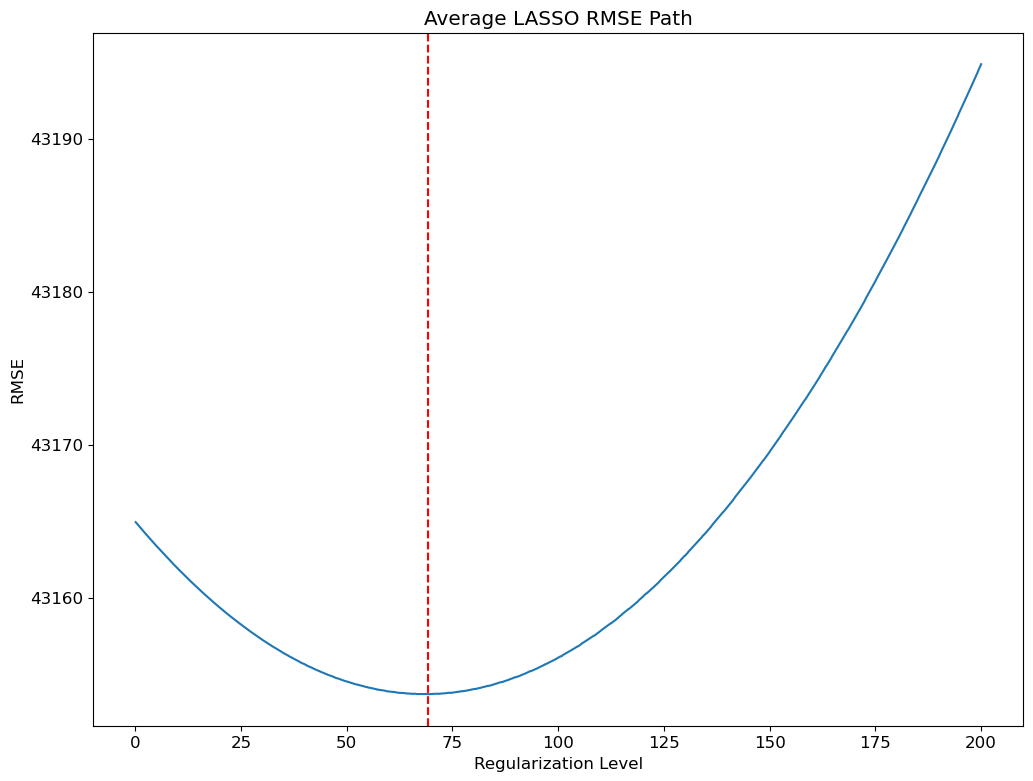

In [40]:
plt.plot(alphas, rmses)
plt.axvline(x=optimal_alpha, color='red', linestyle='dashed')
ax = plt.gca()
ax.set_title('Average LASSO RMSE Path')
ax.set_xlabel('Regularization Level')
ax.set_ylabel('RMSE')

### 2.4.2 A simplified approach to Lasso and CV

Here we perform another L1-regularized regression but using `LassoCV`.  This is more in line with what we expect from you code-wise.  That being said, you should still understand the concepts from the previous section.

In [224]:
# Process the data
X_train, y_train = process_data_gm2(train)
X_test, y_test = process_data_gm2(test)

# Specify the model, alphas, and number of folds for CV
alphas = np.arange(0.1, 200.1, .1)
guidedmodel2 = lm.LassoCV(alphas=alphas, cv=5)

# Fit and predict
guidedmodel2.fit(X_train, y_train)
y_predicted = guidedmodel2.predict(X_test)

print(f'The validation RMSE for this model with '
      f'alpha={round(float(guidedmodel2.alpha_), 2)} is '
      f'{round(rmse(y_test, y_predicted), 2)}.')

/Applications/anaconda3/envs/datasci/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Applications/anaconda3/envs/datasci/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Again, we can map out the path that the Lasso algorithm took.

In [225]:
plt.plot(guidedmodel2.alphas_, np.sqrt(np.apply_along_axis(np.mean, 1, guidedmodel2.mse_path_)))
plt.axvline(x=optimal_alpha, color='red', linestyle='dashed')
ax = plt.gca()
ax.set_title('Average LASSO RMSE Path')
ax.set_xlabel('alpha')
ax.set_ylabel('RMSE')

Text(0, 0.5, 'RMSE')

### 2.4.3 Lasso Residual Plot

Looking at the residual plot for our L1 regularized linear model, it's clear the regularization did not solve the problems we saw in the simple model.  It seems you have your work cut out for you!

Text(0, 0.5, 'Residuals (Actual Price - Predicted Price)')

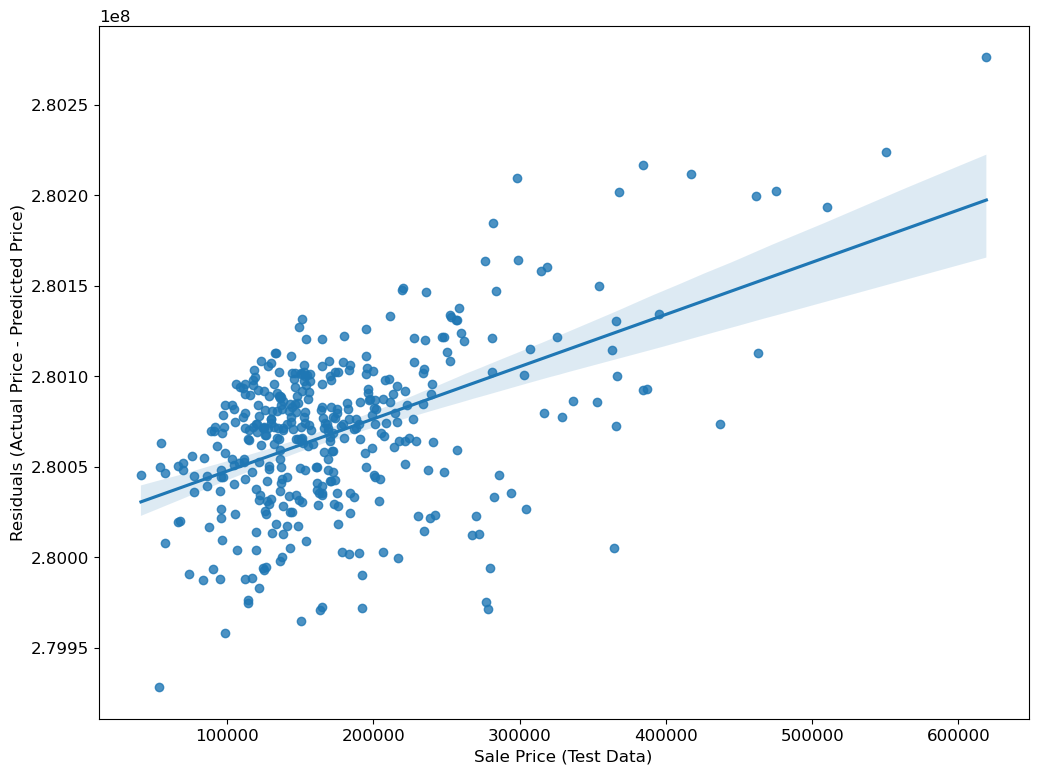

In [226]:
gm2_residuals = y_test - y_predicted
ax = sns.regplot(x=y_test, y=gm2_residuals)
ax.set_xlabel('Sale Price (Test Data)')
ax.set_ylabel('Residuals (Actual Price - Predicted Price)')

# 3. Open-Response

The second part of the assignment is purposefully left nearly open-ended. The data in your possession comes from a larger data set. Your goal is to provide a linear model (linear regression, Lasso, Ridge, or other) that accurately predicts the prices of the held-out homes, measured by root mean square error.

Please note, that we have intentionally left a part of the testing dataset for ourselves that we are going to check your models for overfitting.

### Grading Scheme

For the open-response text, we will be checking your approach and whether you followed a proper modeling pipeline and we will also be checking your error on a smaller test set we kept aside for this purpose.

### Deliverables

#### Question 3 <a name="q3"></a>

Just as in the guided model above, you should encapsulate as much of your workflow into functions as possible.  Define `process_data_fm` and `final model` in the cell below. In order to calculate your final model's RMSE, we will run the code in the cell after that.

In [227]:
training_data = pd.read_csv("ames_train.csv")
test_data = pd.read_csv("ames_test.csv")

In [228]:
# my own function to remove outliers, but this isn't much different than the one before

def remove_outliers(dataframe, selected_columns, iqr_multiplier):
    # get iqr
    for column in selected_columns:
        if pd.api.types.is_numeric_dtype(dataframe[column]): # we check for numeric data only, makes no sense to check for outliers otherwise
            col_dta = np.array(dataframe[column].values) # get column into np.array
            iqr = np.percentile(col_dta, 75) - np.percentile(col_dta, 25) # interquartile range (removing outliers based on iqr this time)

            l_bound = np.percentile(col_dta, 25) - (iqr_multiplier * iqr)
            u_bound = np.percentile(col_dta, 75) + (iqr_multiplier * iqr)

            no_outlier_data = dataframe[(col_dta >= l_bound) & (col_dta <= u_bound)]
            
            dataframe = no_outlier_data

    return dataframe

remove_outliers(training_data, ['SalePrice'], 3)

Order        PID  MS_SubClass MS_Zoning  Lot_Frontage  Lot_Area Street  \
0         1  526301100           20        RL         141.0     31770   Pave   
1         2  526350040           20        RH          80.0     11622   Pave   
2         3  526351010           20        RL          81.0     14267   Pave   
3         4  526353030           20        RL          93.0     11160   Pave   
4         5  527105010           60        RL          74.0     13830   Pave   
...     ...        ...          ...       ...           ...       ...    ...   
1972   2885  911370530          120        RM          44.0      3842   Pave   
1973   2890  914476130           80        RL         140.0     11080   Pave   
1974   2892  916225130           60        RL          42.0     26178   Pave   
1975   2893  916252170          120        RM           NaN      8239   Pave   
1976   2894  916325040           20        RL           NaN     50102   Pave   

     Alley Lot_Shape Land_Contour  ... Pool_Area Pool_QC  Fence Misc_Feature  \
0      NaN       IR1          Lvl  ...         0     NaN    NaN          NaN   
1      NaN       Reg          Lvl  ...         0     NaN  MnPrv          NaN   
2      NaN       IR1          Lvl  ...         0     NaN    NaN         Gar2   
3      NaN       Reg          Lvl  ...         0     NaN    NaN          NaN   
4      NaN       IR1          Lvl  ...         0     NaN  MnPrv          NaN   
...    ...       ...          ...  ...       ...     ...    ...          ...   
1972   NaN       IR1          HLS  ...         0     NaN    NaN          NaN   
1973   NaN       Reg          Lvl  ...         0     NaN    NaN          NaN   
1974   NaN       IR1          Lvl  ...         0     NaN    NaN          NaN   
1975   NaN       IR1          Lvl  ...         0     NaN    NaN          NaN   
1976   NaN       IR1          Low  ...         0     NaN    NaN          NaN   

     Misc_Val Mo_Sold Yr_Sold Sale_Type  Sale_Condition  SalePrice  
0           0       5    2010        WD          Normal     204900  
1           0       6    2010        WD          Normal      95300  
2       12500       6    2010        WD          Normal     181900  
3           0       4    2010        WD          Normal     254100  
4           0       3    2010        WD          Normal     199700  
...       ...     ...     ...       ...             ...        ...  
1972        0      12    2006        WD          Normal     294300  
1973        0       5    2006        WD          Normal     154300  
1974        0       4    2006        WD          Normal     329000  
1975        0      11    2006        WD          Normal     235900  
1976        0       3    2006        WD          Alloca     256764  

[1958 rows x 82 columns]

In [229]:
def count_missing_data(dataframe): # this will help me check the columns which are not usable
    missing_val_count_dict = {}
    for column in dataframe.columns:
        missing_val_count = dataframe[column].isnull().sum()
        missing_val_count_dict[column] = missing_val_count

    return missing_val_count_dict

print(count_missing_data(training_data))

def drop_columns_missing_values(dataframe, bound, include = None): #  gets rid of columns with more than 100 missing values, I do not want to use them
    for column in dataframe.columns:
        if column in include: # important to not remove columns where missing values are just a "no"
            missing_val_count = dataframe[column].isnull().sum()
            if missing_val_count > bound:
                dataframe = dataframe.drop(column, axis = 1)

    return dataframe

drop_columns_missing_values(training_data, 200, include = ['Lot_Frontage']) # a lot of the values have NaN but this just means "no"

{'Order': 0, 'PID': 0, 'MS_SubClass': 0, 'MS_Zoning': 0, 'Lot_Frontage': 347, 'Lot_Area': 0, 'Street': 0, 'Alley': 1844, 'Lot_Shape': 0, 'Land_Contour': 0, 'Utilities': 0, 'Lot_Config': 0, 'Land_Slope': 0, 'Neighborhood': 0, 'Condition_1': 0, 'Condition_2': 0, 'Bldg_Type': 0, 'House_Style': 0, 'Overall_Qual': 0, 'Overall_Cond': 0, 'Year_Built': 0, 'Year_Remod/Add': 0, 'Roof_Style': 0, 'Roof_Matl': 0, 'Exterior_1st': 0, 'Exterior_2nd': 0, 'Mas_Vnr_Type': 1204, 'Mas_Vnr_Area': 18, 'Exter_Qual': 0, 'Exter_Cond': 0, 'Foundation': 0, 'Bsmt_Qual': 56, 'Bsmt_Cond': 56, 'Bsmt_Exposure': 57, 'BsmtFin_Type_1': 56, 'BsmtFin_SF_1': 1, 'BsmtFin_Type_2': 56, 'BsmtFin_SF_2': 1, 'Bsmt_Unf_SF': 1, 'Total_Bsmt_SF': 1, 'Heating': 0, 'Heating_QC': 0, 'Central_Air': 0, 'Electrical': 1, '1st_Flr_SF': 0, '2nd_Flr_SF': 0, 'Low_Qual_Fin_SF': 0, 'Gr_Liv_Area': 0, 'Bsmt_Full_Bath': 2, 'Bsmt_Half_Bath': 2, 'Full_Bath': 0, 'Half_Bath': 0, 'Bedroom_AbvGr': 0, 'Kitchen_AbvGr': 0, 'Kitchen_Qual': 0, 'TotRms_AbvGrd': 

Order        PID  MS_SubClass MS_Zoning  Lot_Area Street Alley  \
0         1  526301100           20        RL     31770   Pave   NaN   
1         2  526350040           20        RH     11622   Pave   NaN   
2         3  526351010           20        RL     14267   Pave   NaN   
3         4  526353030           20        RL     11160   Pave   NaN   
4         5  527105010           60        RL     13830   Pave   NaN   
...     ...        ...          ...       ...       ...    ...   ...   
1972   2885  911370530          120        RM      3842   Pave   NaN   
1973   2890  914476130           80        RL     11080   Pave   NaN   
1974   2892  916225130           60        RL     26178   Pave   NaN   
1975   2893  916252170          120        RM      8239   Pave   NaN   
1976   2894  916325040           20        RL     50102   Pave   NaN   

     Lot_Shape Land_Contour Utilities  ... Pool_Area Pool_QC  Fence  \
0          IR1          Lvl    AllPub  ...         0     NaN    NaN   
1          Reg          Lvl    AllPub  ...         0     NaN  MnPrv   
2          IR1          Lvl    AllPub  ...         0     NaN    NaN   
3          Reg          Lvl    AllPub  ...         0     NaN    NaN   
4          IR1          Lvl    AllPub  ...         0     NaN  MnPrv   
...        ...          ...       ...  ...       ...     ...    ...   
1972       IR1          HLS    AllPub  ...         0     NaN    NaN   
1973       Reg          Lvl    AllPub  ...         0     NaN    NaN   
1974       IR1          Lvl    AllPub  ...         0     NaN    NaN   
1975       IR1          Lvl    AllPub  ...         0     NaN    NaN   
1976       IR1          Low    AllPub  ...         0     NaN    NaN   

     Misc_Feature Misc_Val Mo_Sold Yr_Sold  Sale_Type  Sale_Condition  \
0             NaN        0       5    2010         WD          Normal   
1             NaN        0       6    2010         WD          Normal   
2            Gar2    12500       6    2010         WD          Normal   
3             NaN        0       4    2010         WD          Normal   
4             NaN        0       3    2010         WD          Normal   
...           ...      ...     ...     ...        ...             ...   
1972          NaN        0      12    2006         WD          Normal   
1973          NaN        0       5    2006         WD          Normal   
1974          NaN        0       4    2006         WD          Normal   
1975          NaN        0      11    2006         WD          Normal   
1976          NaN        0       3    2006         WD          Alloca   

      SalePrice  
0        204900  
1         95300  
2        181900  
3        254100  
4        199700  
...         ...  
1972     294300  
1973     154300  
1974     329000  
1975     235900  
1976     256764  

[1977 rows x 81 columns]

In [230]:
def replace_wrong_NA(dataframe, exclude=None):
    columns_to_replace = [col for col in dataframe.columns if col not in (exclude or [])]

    for column in columns_to_replace:
        dataframe[column].fillna("NA", inplace=True)

    return dataframe

replace_wrong_NA(training_data, ['Order', 'PID'])

/var/folders/28/nqw3v6ld39g_jrhl3y66nq2w0000gn/T/ipykernel_794/1729318459.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'NA' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  dataframe[column].fillna("NA", inplace=True)


Order        PID  MS_SubClass MS_Zoning Lot_Frontage  Lot_Area Street  \
0         1  526301100           20        RL        141.0     31770   Pave   
1         2  526350040           20        RH         80.0     11622   Pave   
2         3  526351010           20        RL         81.0     14267   Pave   
3         4  526353030           20        RL         93.0     11160   Pave   
4         5  527105010           60        RL         74.0     13830   Pave   
...     ...        ...          ...       ...          ...       ...    ...   
1972   2885  911370530          120        RM         44.0      3842   Pave   
1973   2890  914476130           80        RL        140.0     11080   Pave   
1974   2892  916225130           60        RL         42.0     26178   Pave   
1975   2893  916252170          120        RM           NA      8239   Pave   
1976   2894  916325040           20        RL           NA     50102   Pave   

     Alley Lot_Shape Land_Contour  ... Pool_Area Pool_QC  Fence Misc_Feature  \
0       NA       IR1          Lvl  ...         0      NA     NA           NA   
1       NA       Reg          Lvl  ...         0      NA  MnPrv           NA   
2       NA       IR1          Lvl  ...         0      NA     NA         Gar2   
3       NA       Reg          Lvl  ...         0      NA     NA           NA   
4       NA       IR1          Lvl  ...         0      NA  MnPrv           NA   
...    ...       ...          ...  ...       ...     ...    ...          ...   
1972    NA       IR1          HLS  ...         0      NA     NA           NA   
1973    NA       Reg          Lvl  ...         0      NA     NA           NA   
1974    NA       IR1          Lvl  ...         0      NA     NA           NA   
1975    NA       IR1          Lvl  ...         0      NA     NA           NA   
1976    NA       IR1          Low  ...         0      NA     NA           NA   

     Misc_Val Mo_Sold Yr_Sold Sale_Type  Sale_Condition  SalePrice  
0           0       5    2010        WD          Normal     204900  
1           0       6    2010        WD          Normal      95300  
2       12500       6    2010        WD          Normal     181900  
3           0       4    2010        WD          Normal     254100  
4           0       3    2010        WD          Normal     199700  
...       ...     ...     ...       ...             ...        ...  
1972        0      12    2006        WD          Normal     294300  
1973        0       5    2006        WD          Normal     154300  
1974        0       4    2006        WD          Normal     329000  
1975        0      11    2006        WD          Normal     235900  
1976        0       3    2006        WD          Alloca     256764  

[1977 rows x 82 columns]

In [243]:
# this takes a while to actually run, you can do it if needed, but i would not recommend it
# it just was useful to show me all the different relations between saleprice and the other variables

def plot_price_var_boxplot(dataframe):
    for col in dataframe.columns:
        plt.figure(figsize=(8, 5))
        sns.boxplot(data=dataframe, x=col, y='SalePrice')
        plt.title(f'Boxplot for {col}')
        plt.xlabel(col)
        plt.ylabel('SalePrice')
        plt.show()

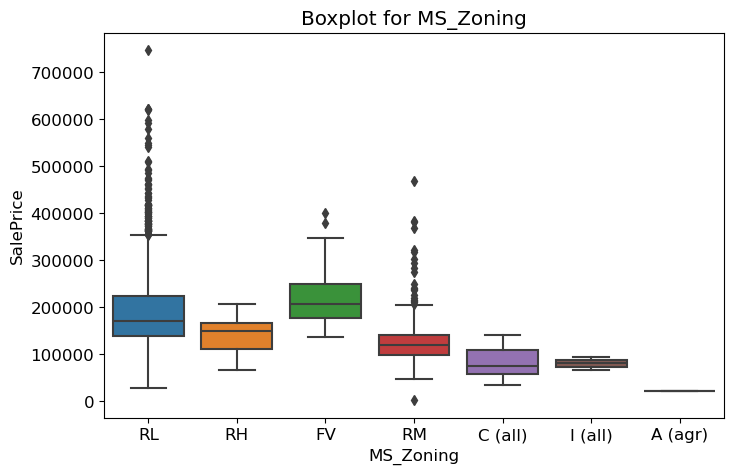

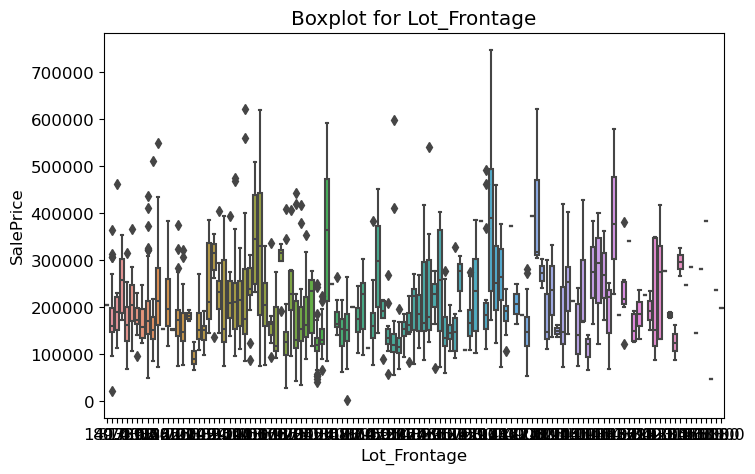

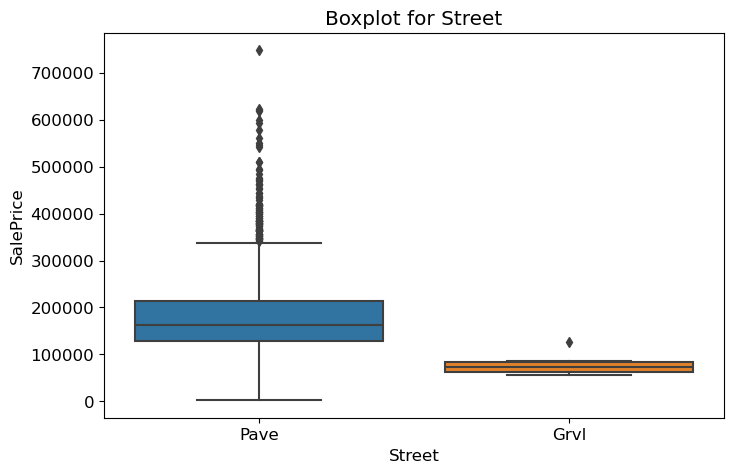

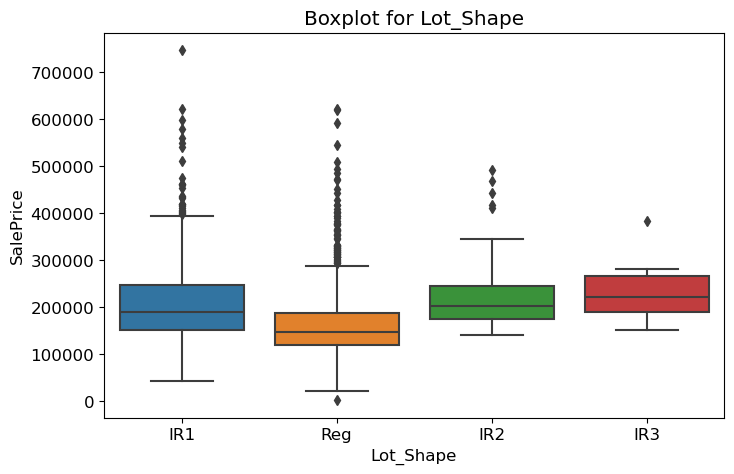

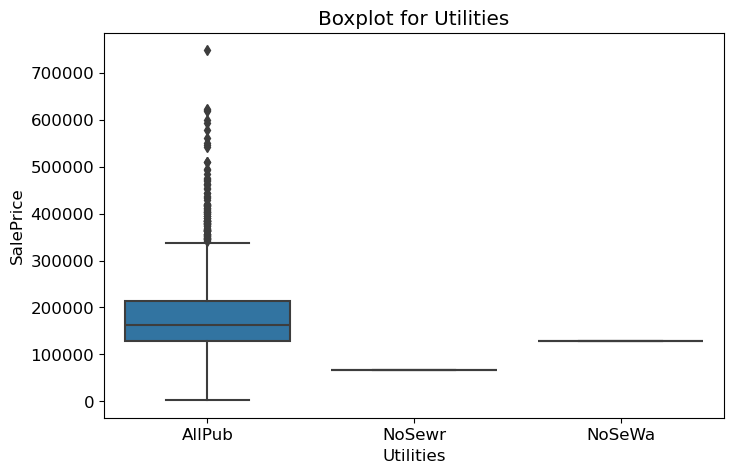

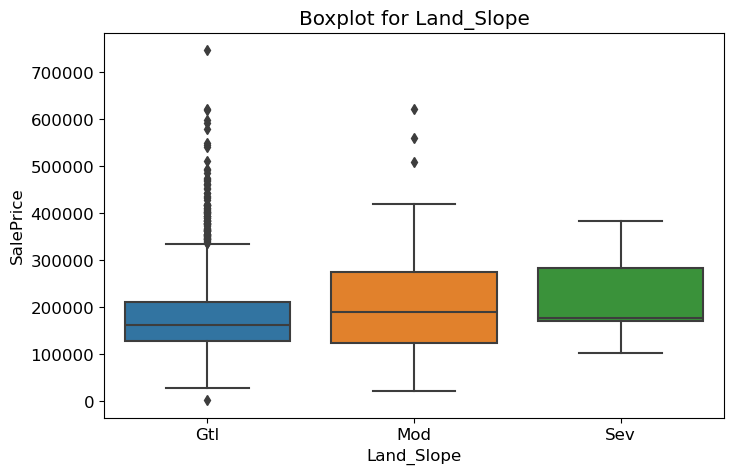

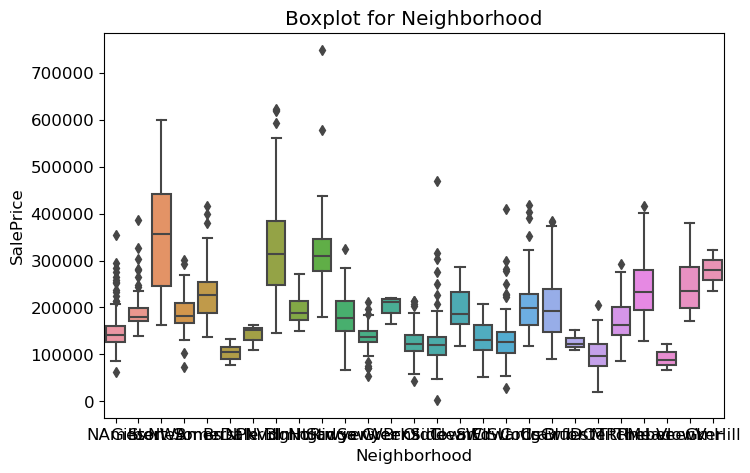

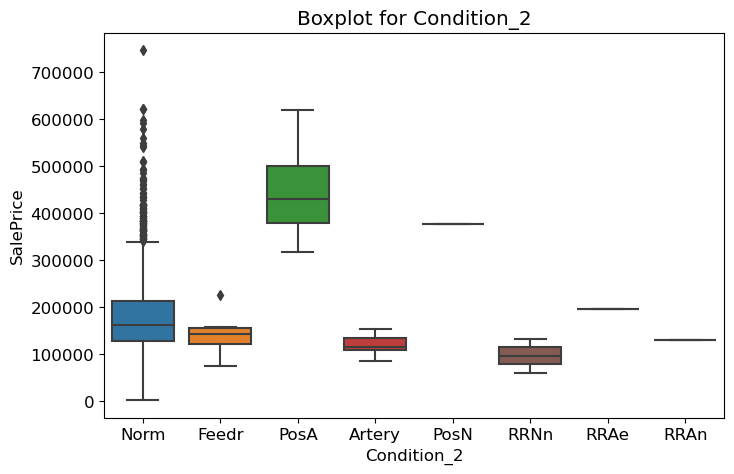

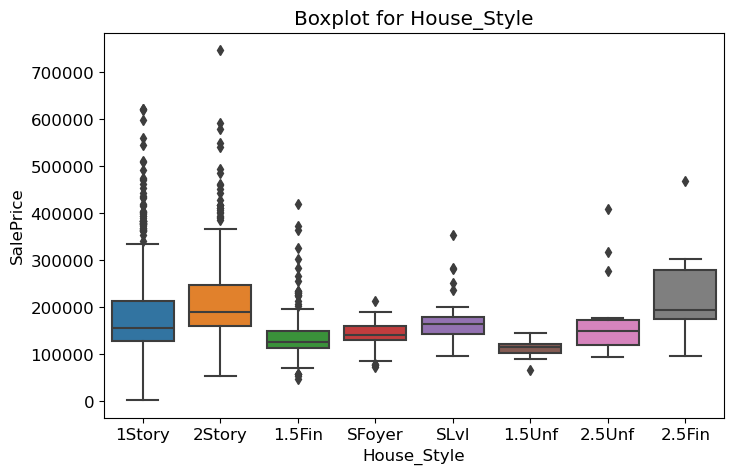

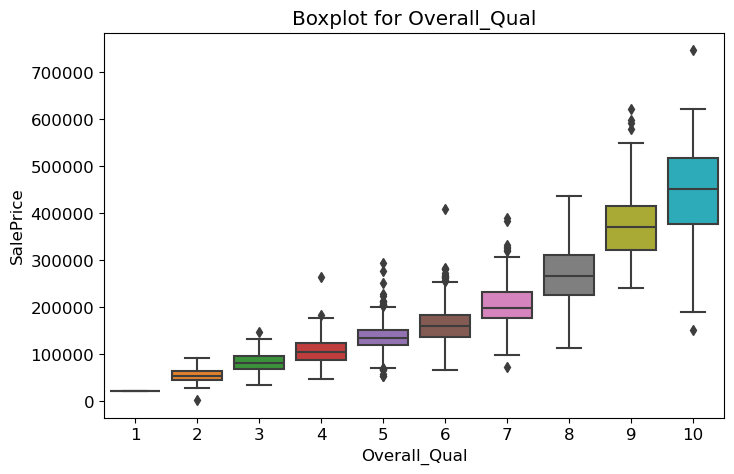

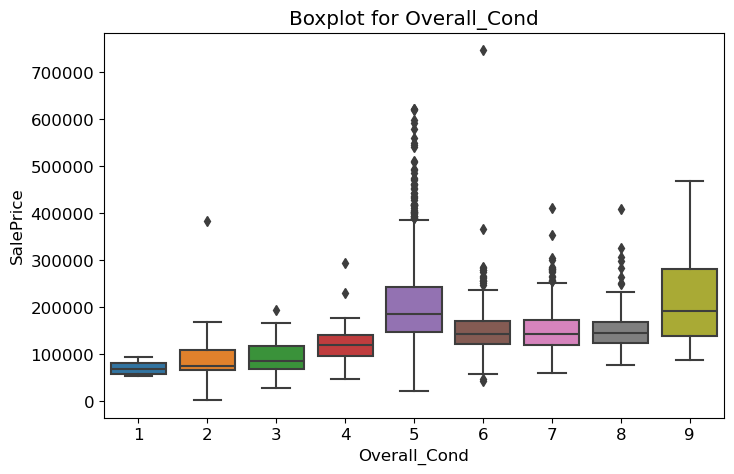

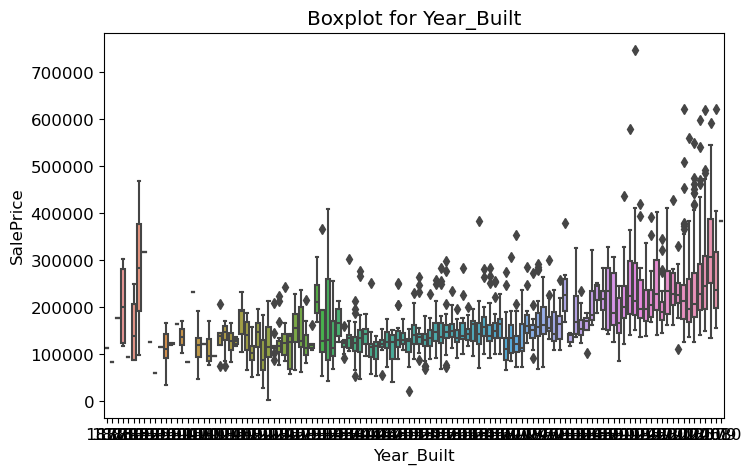

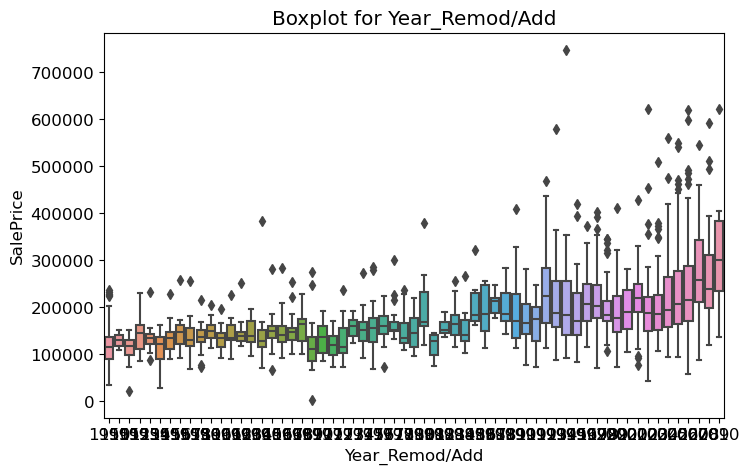

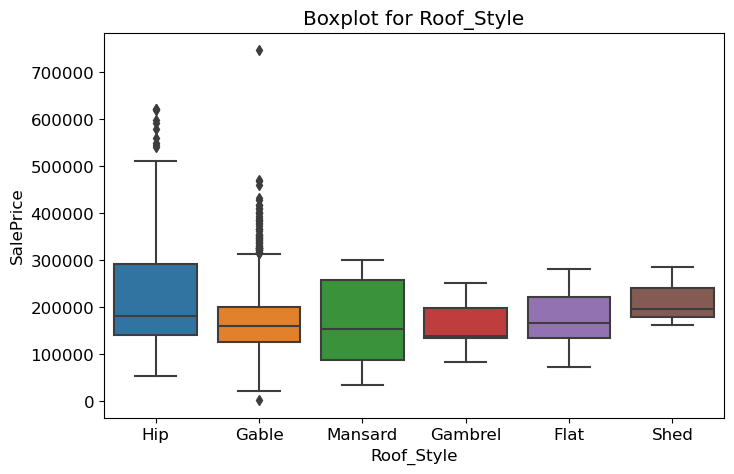

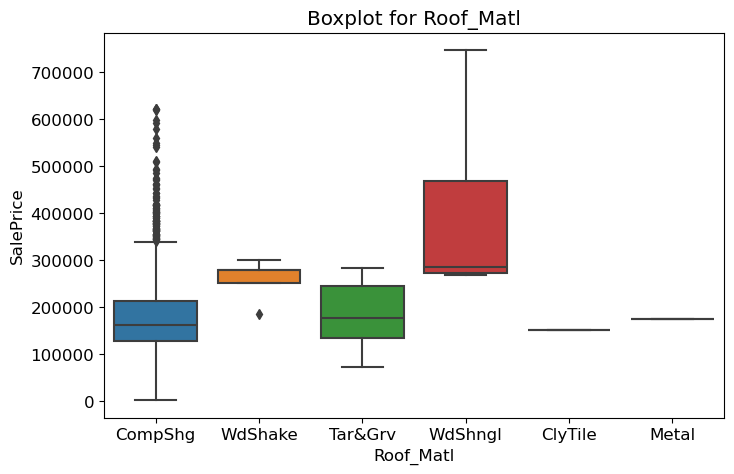

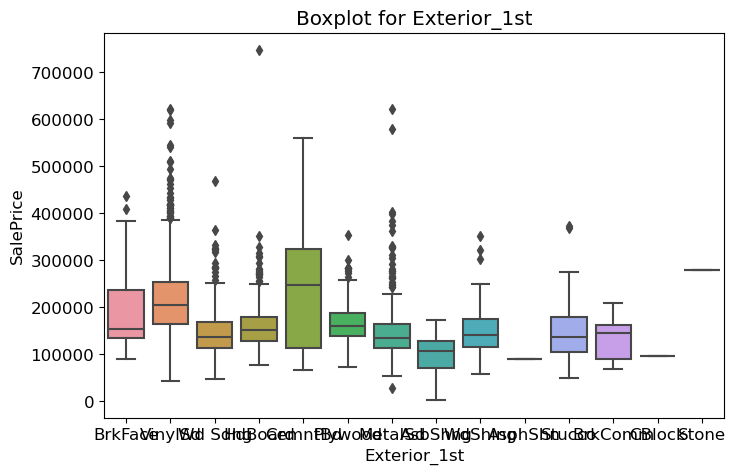

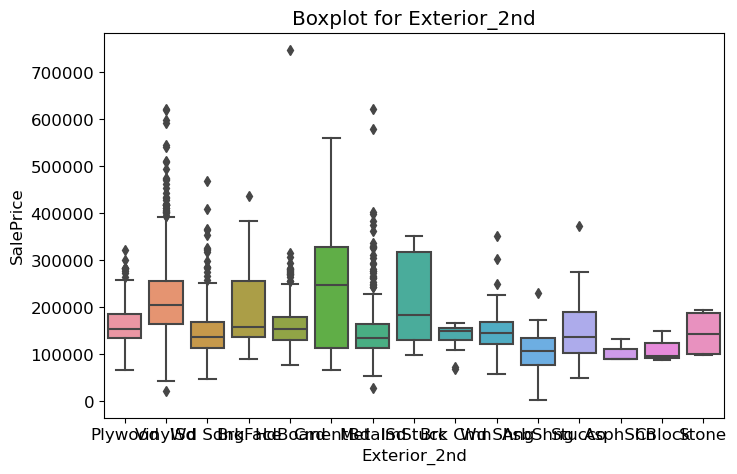

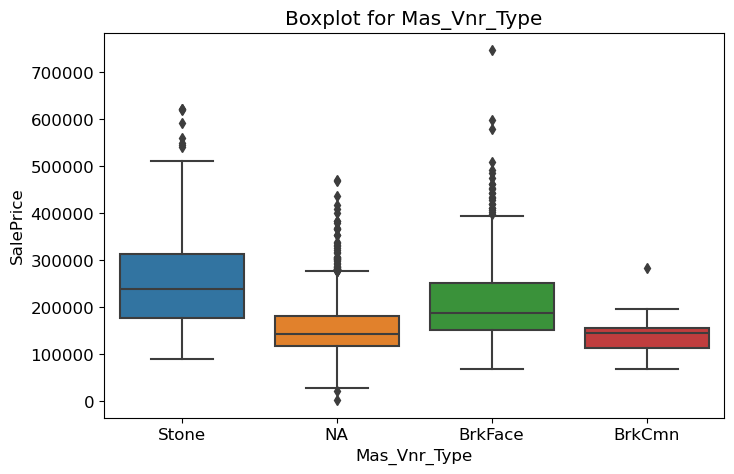

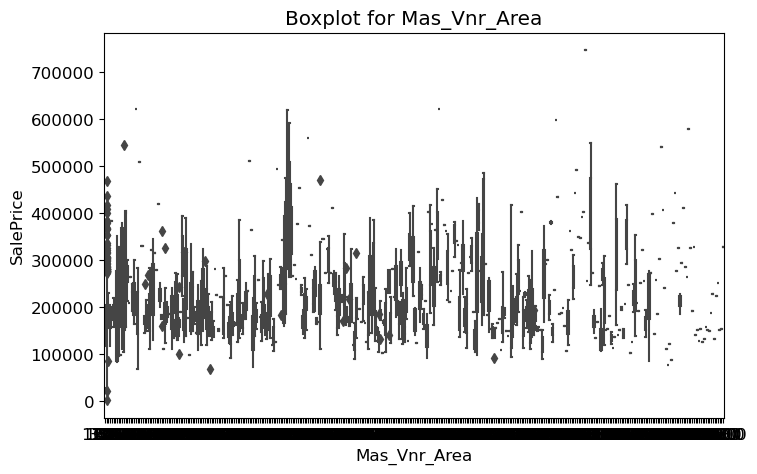

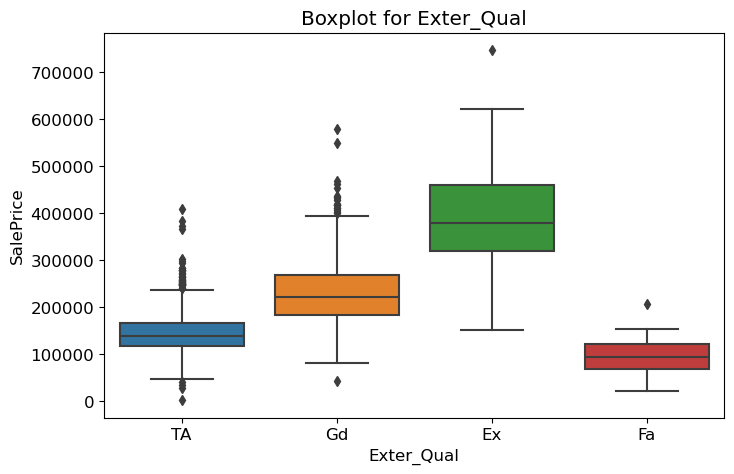

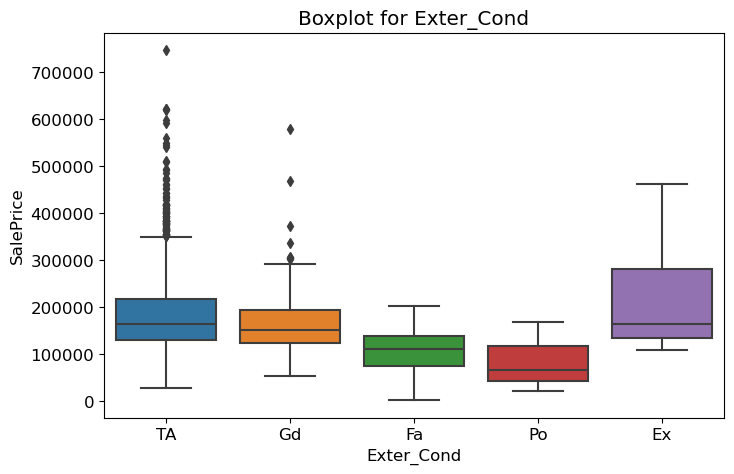

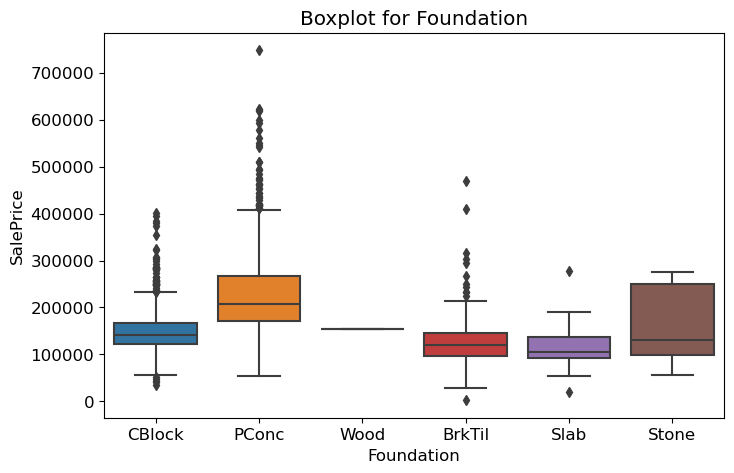

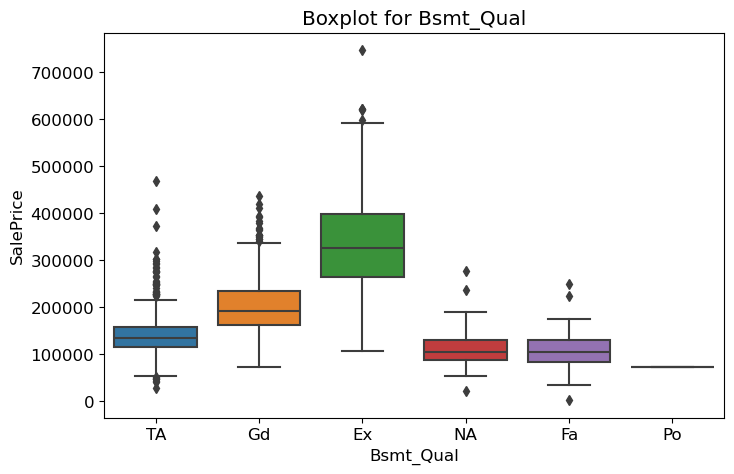

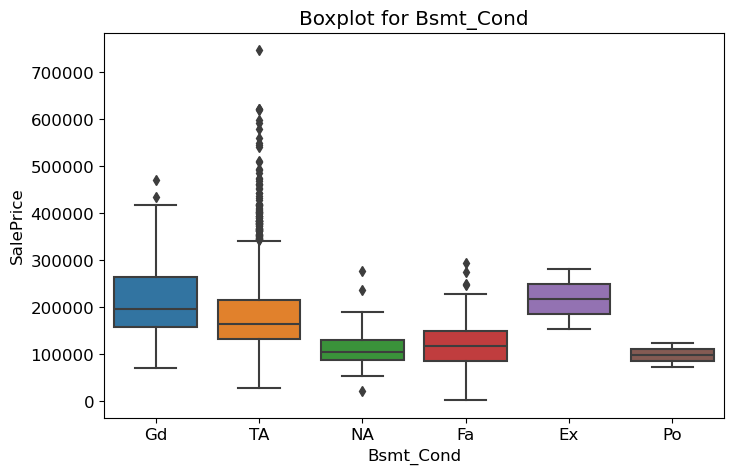

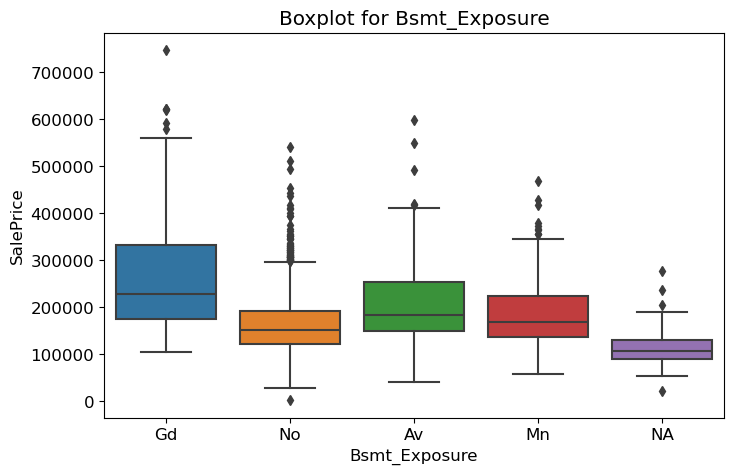

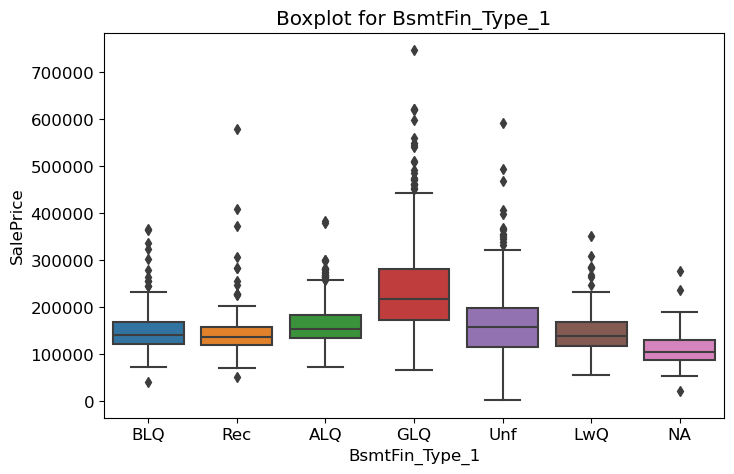

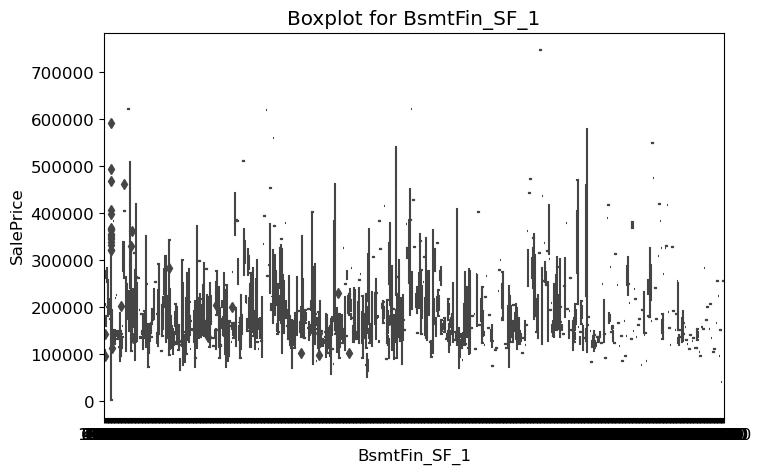

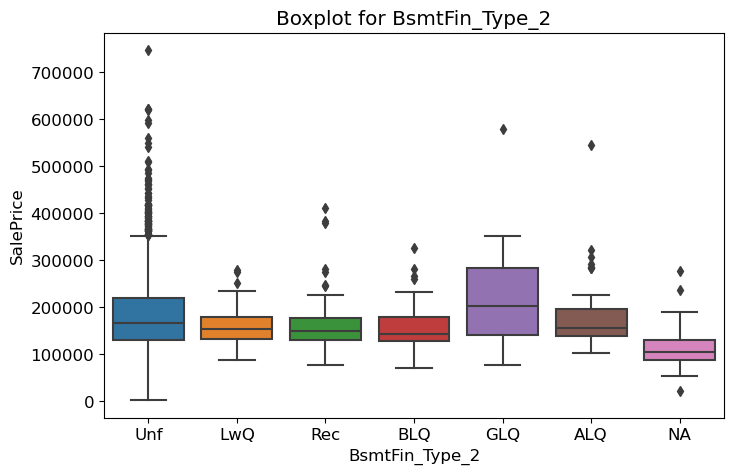

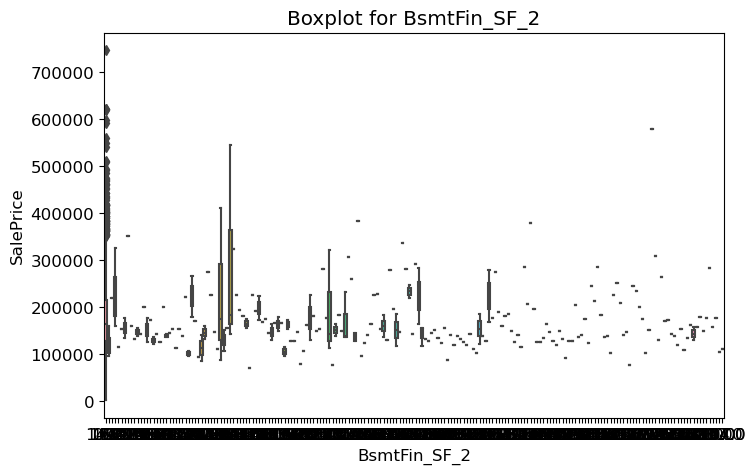

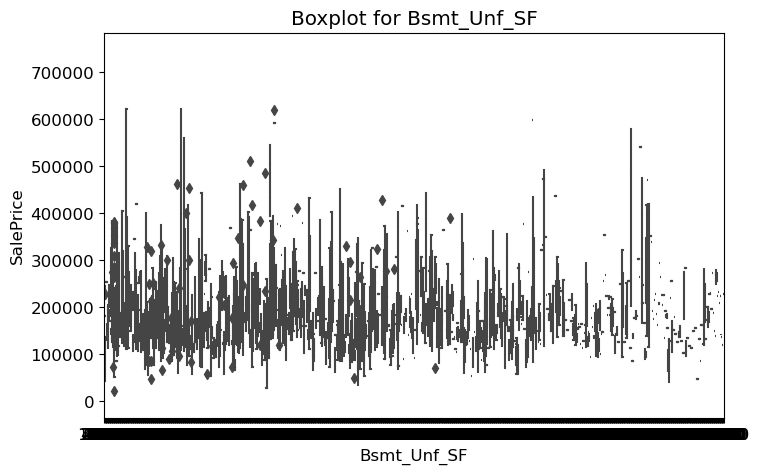

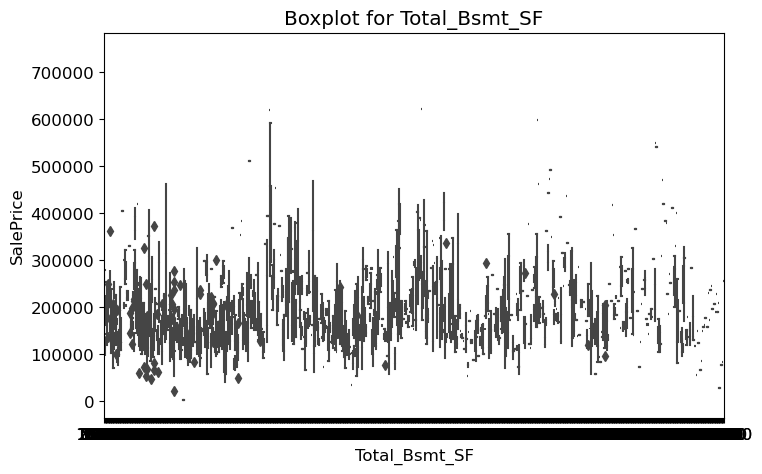

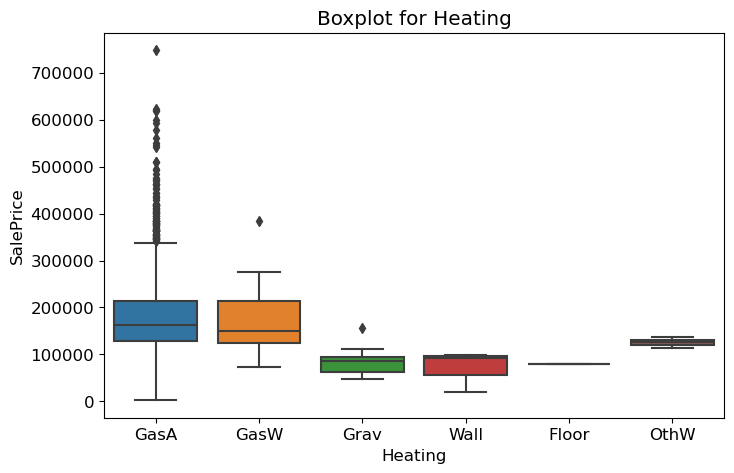

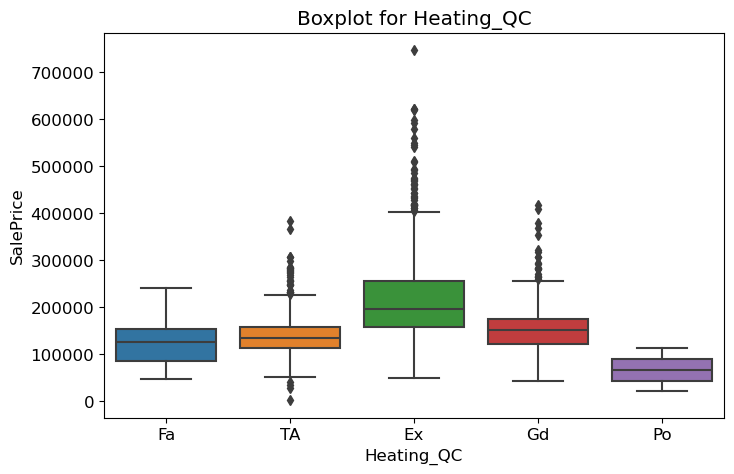

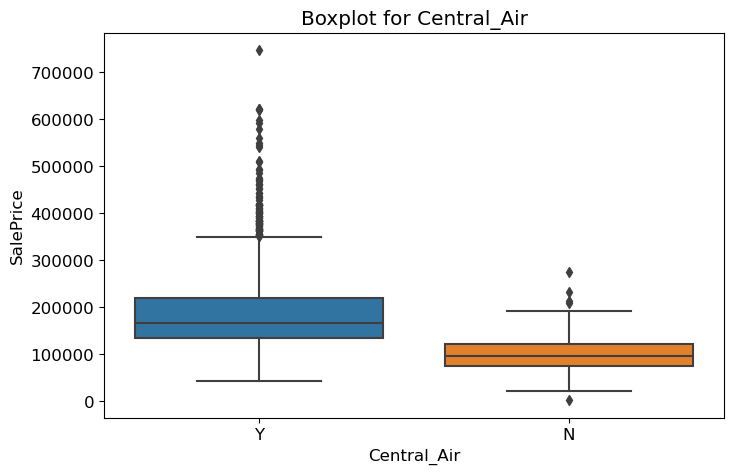

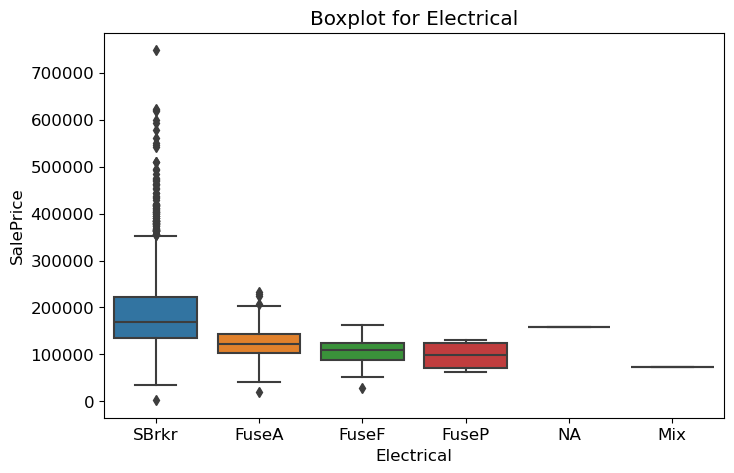

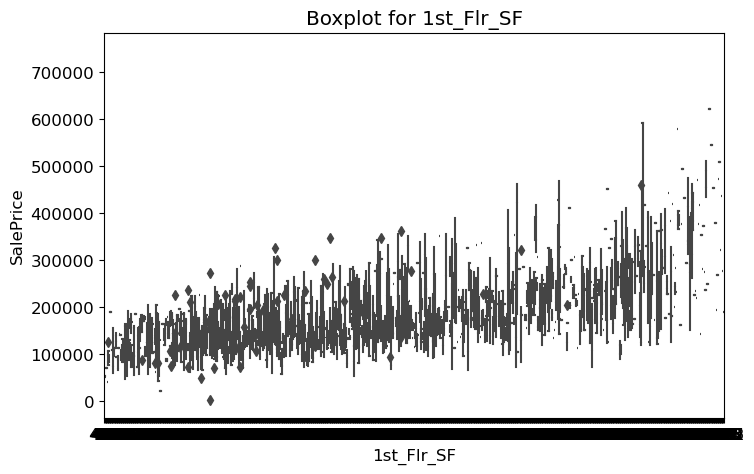

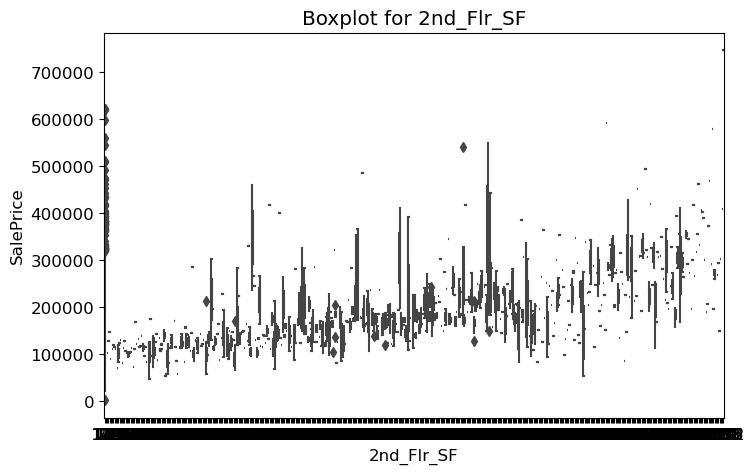

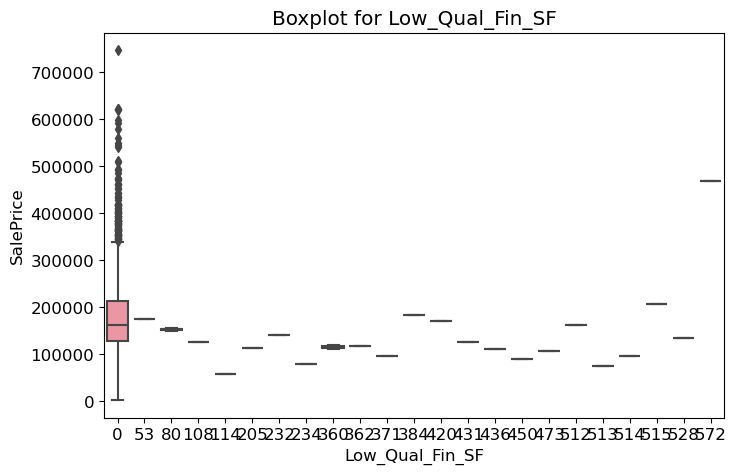

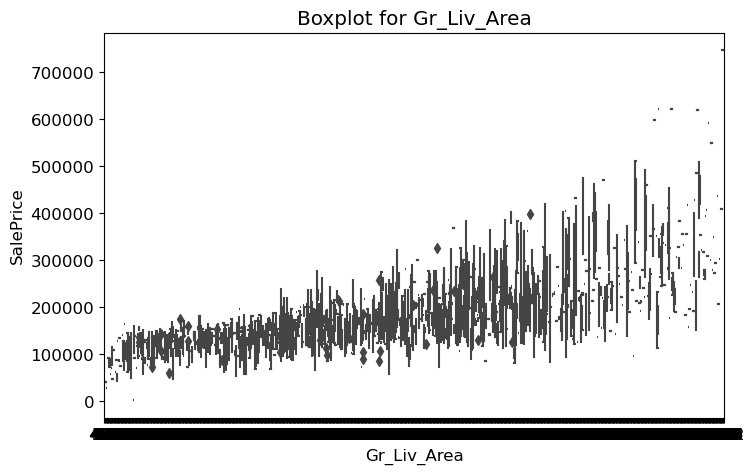

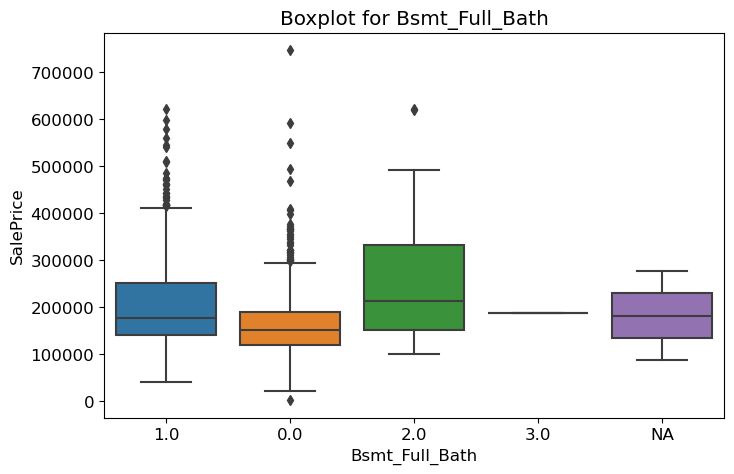

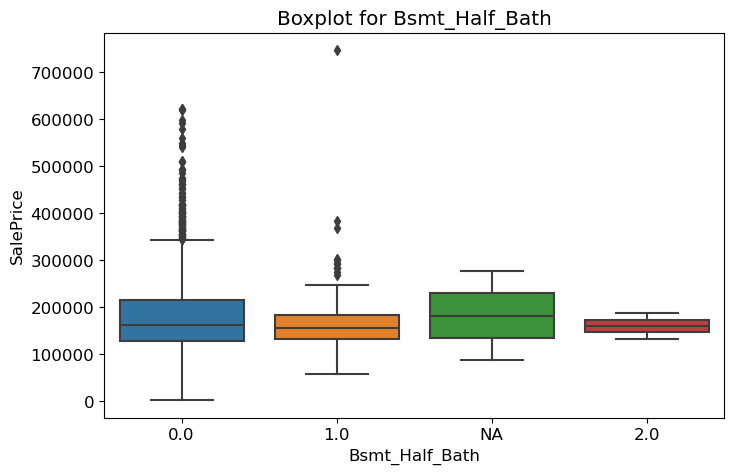

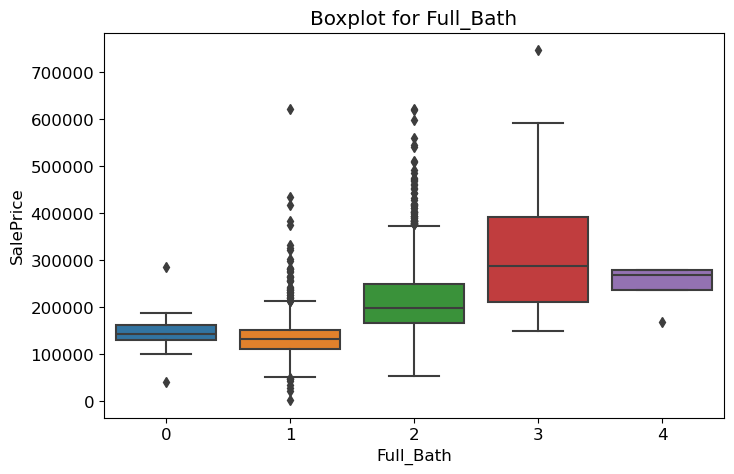

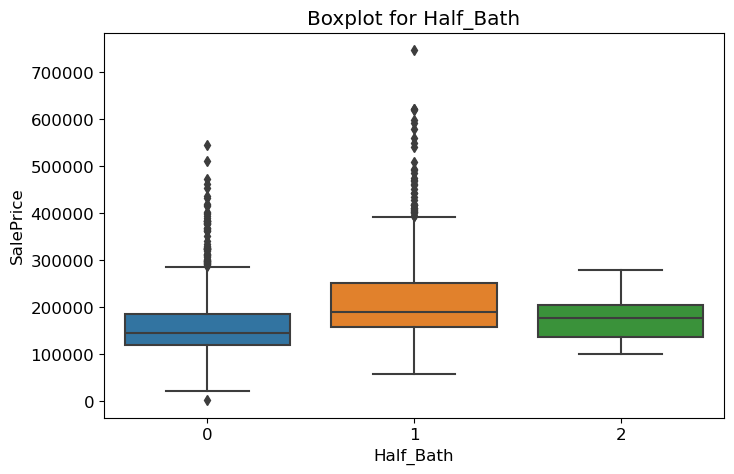

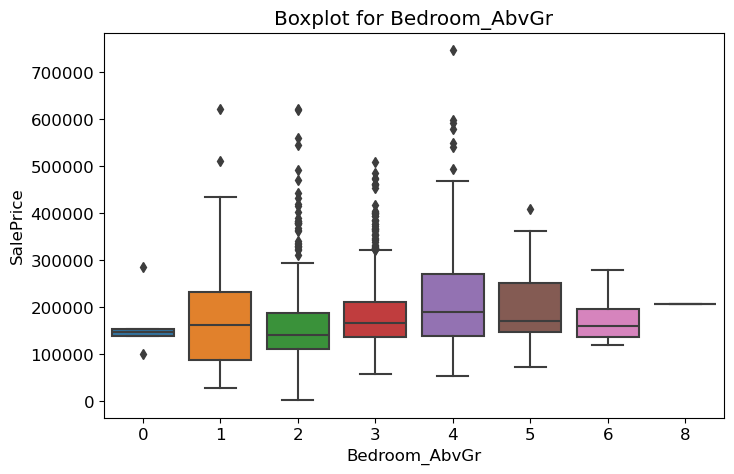

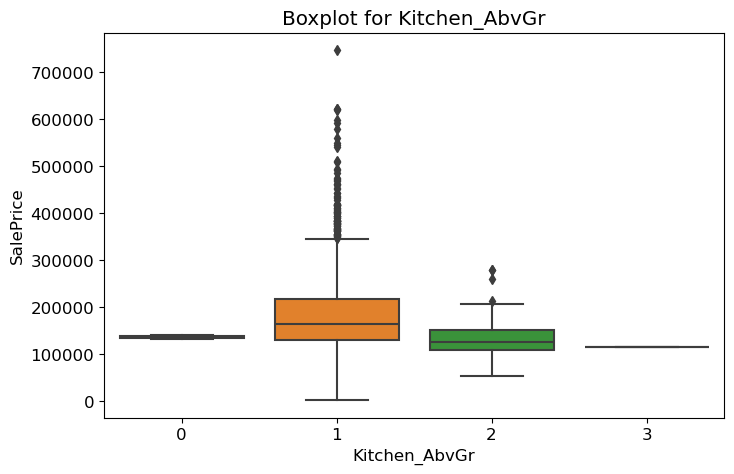

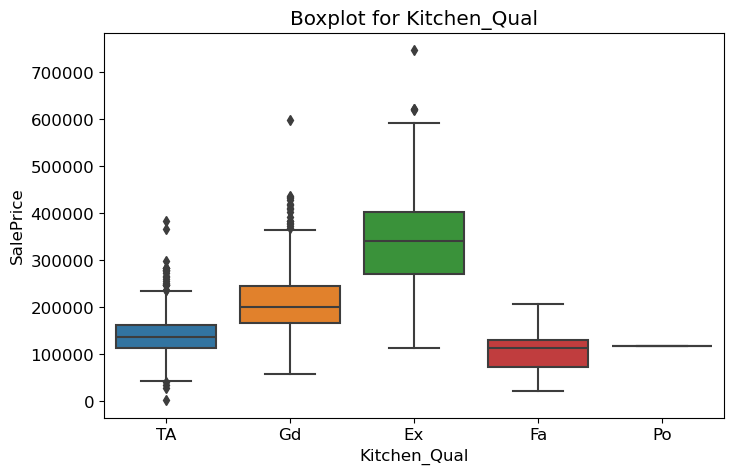

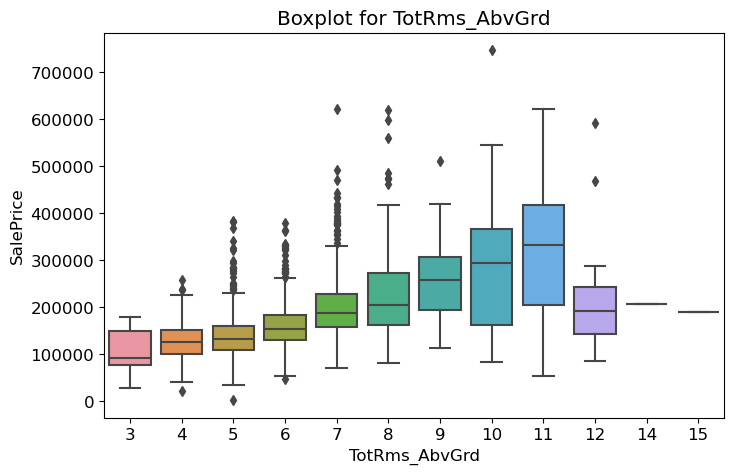

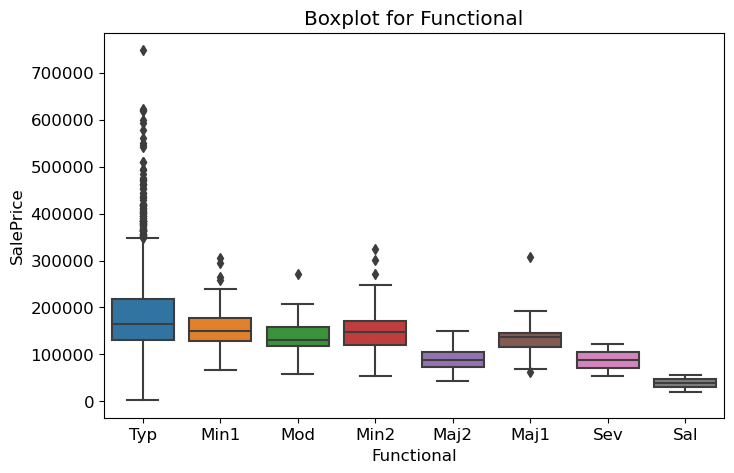

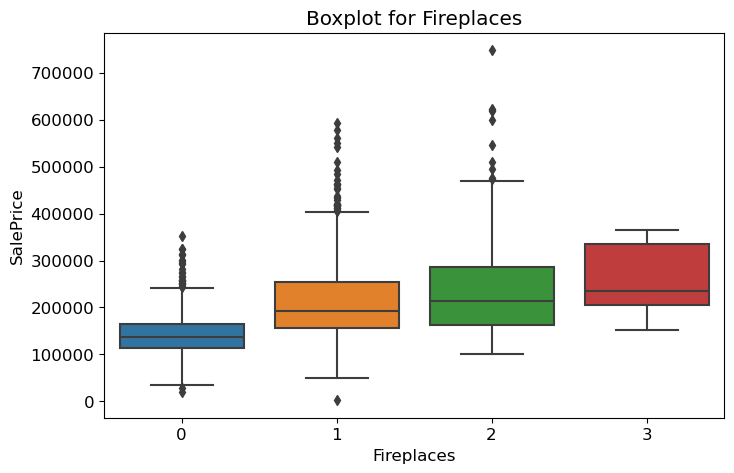

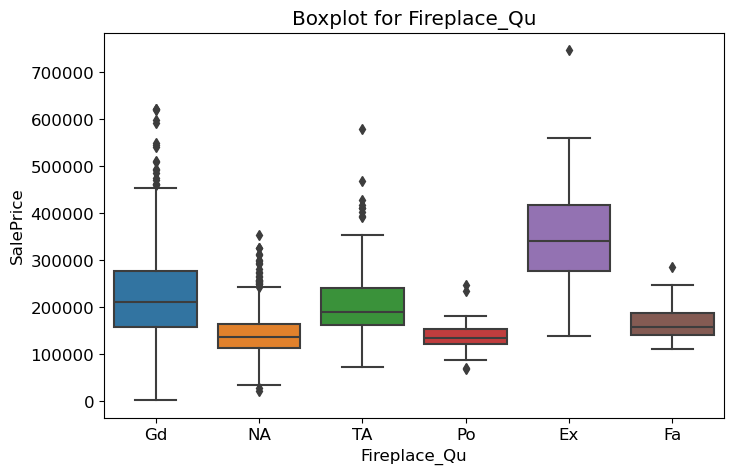

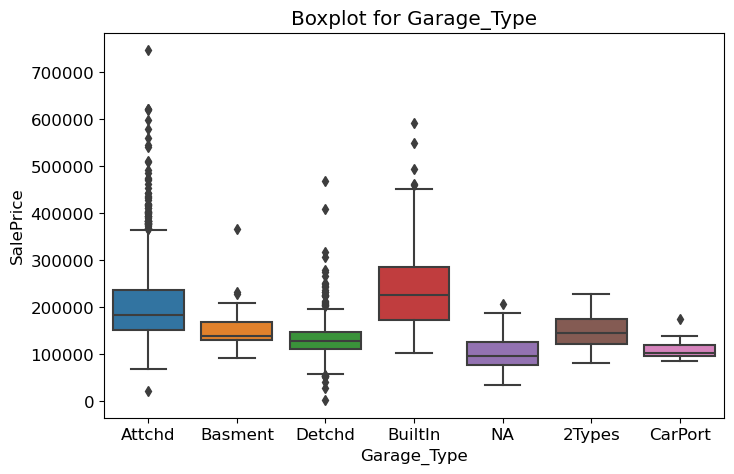

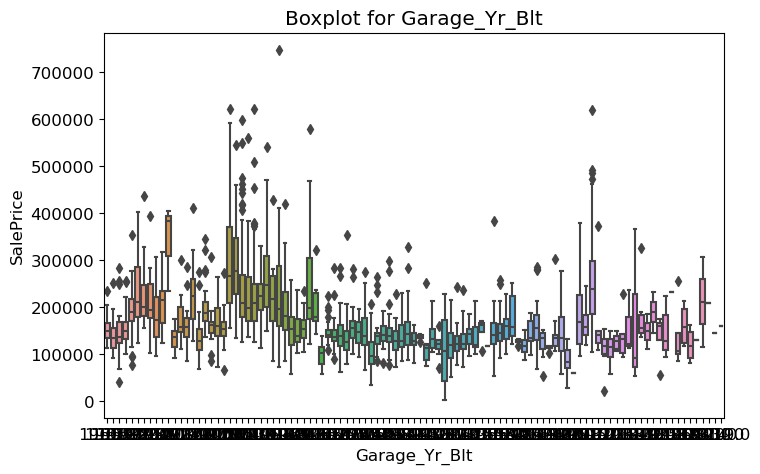

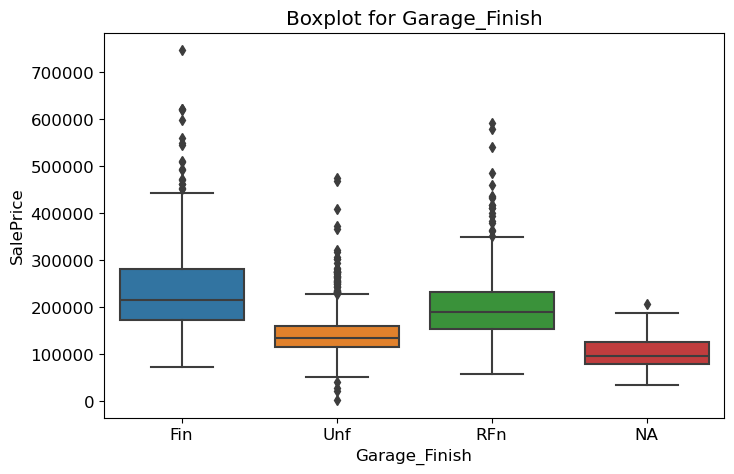

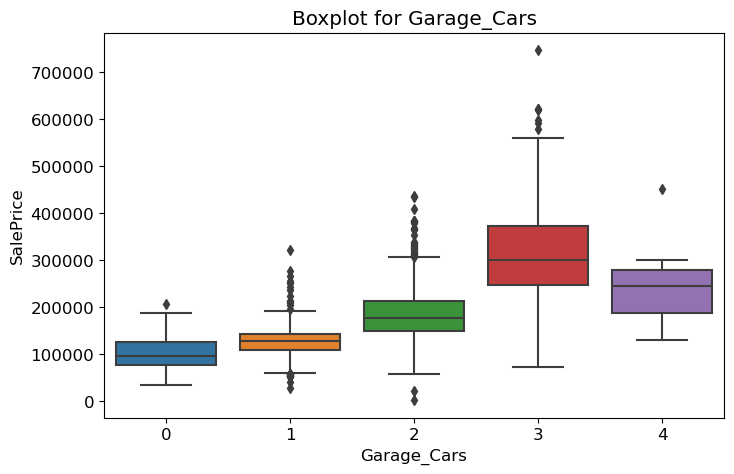

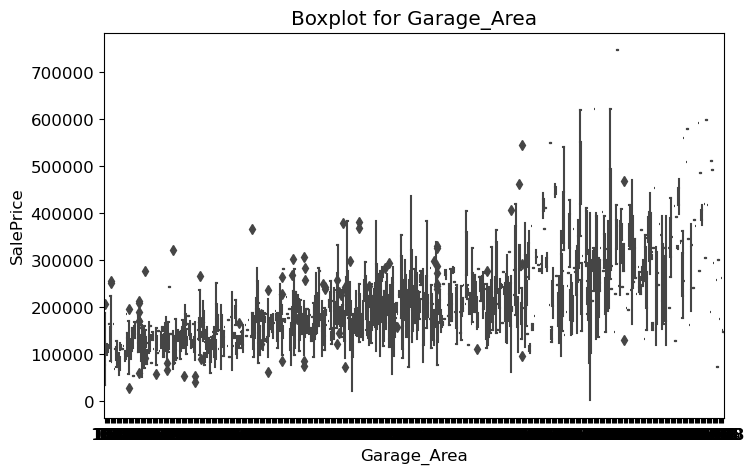

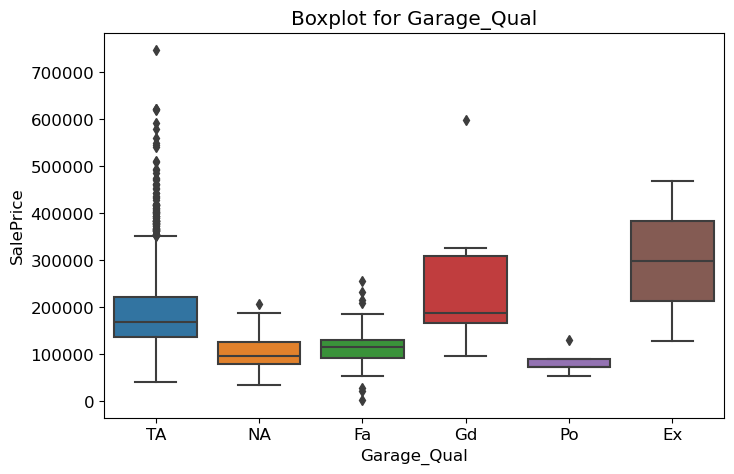

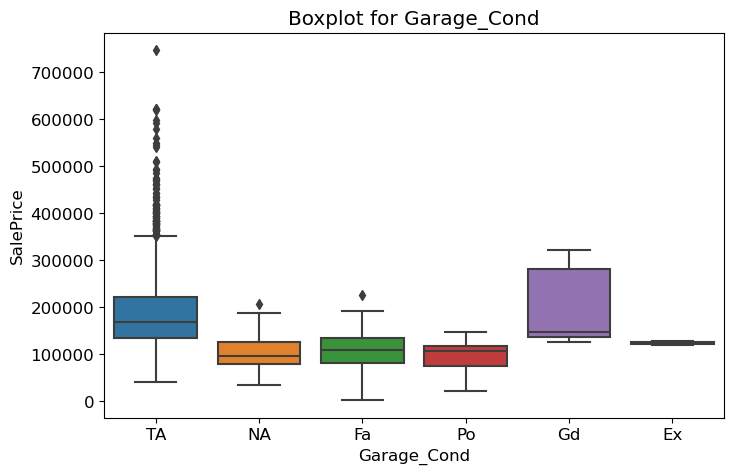

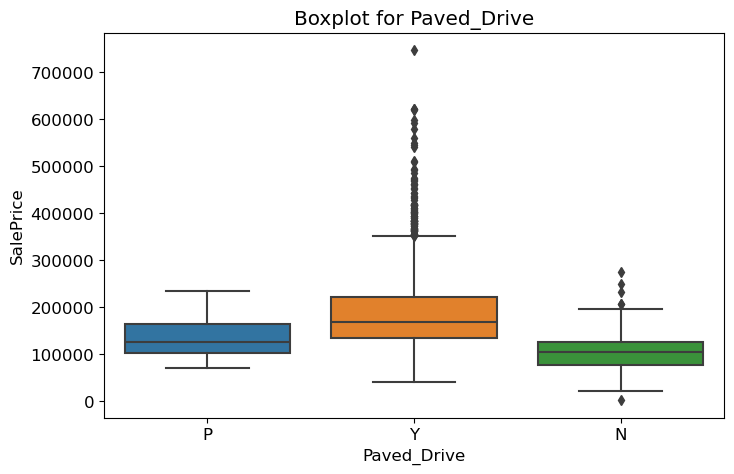

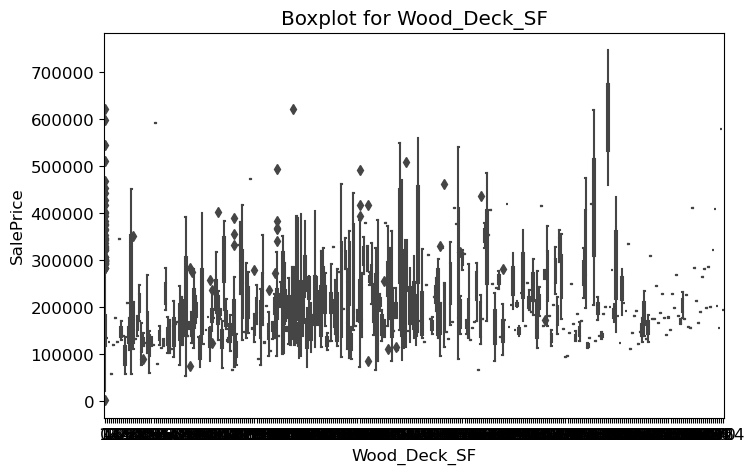

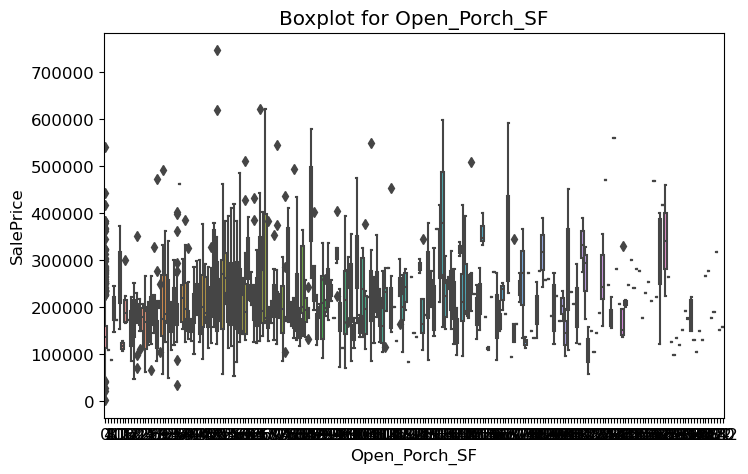

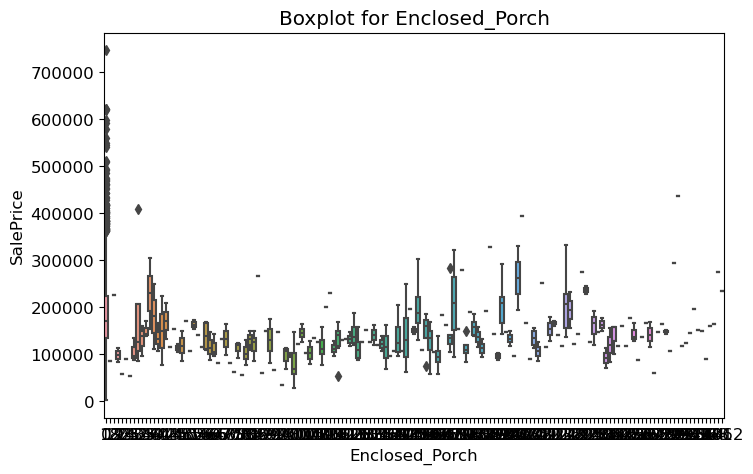

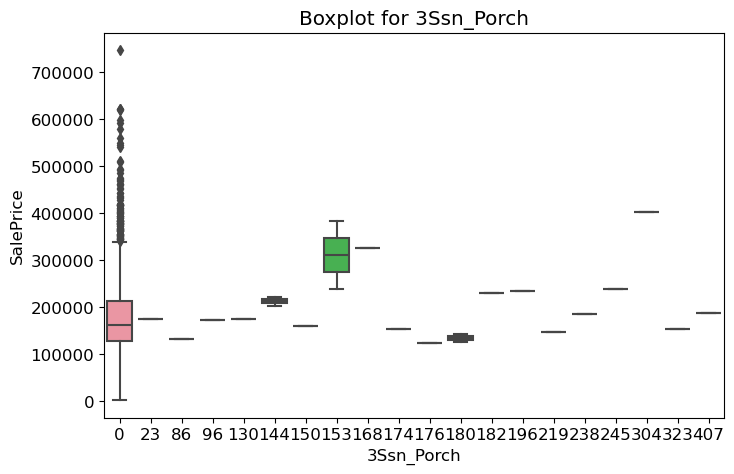

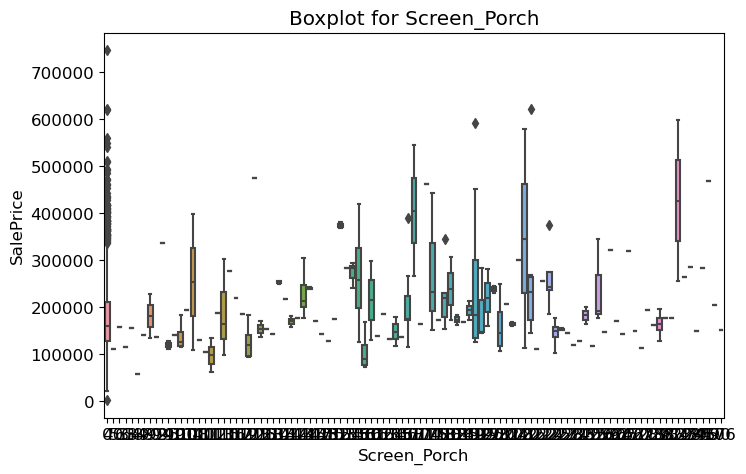

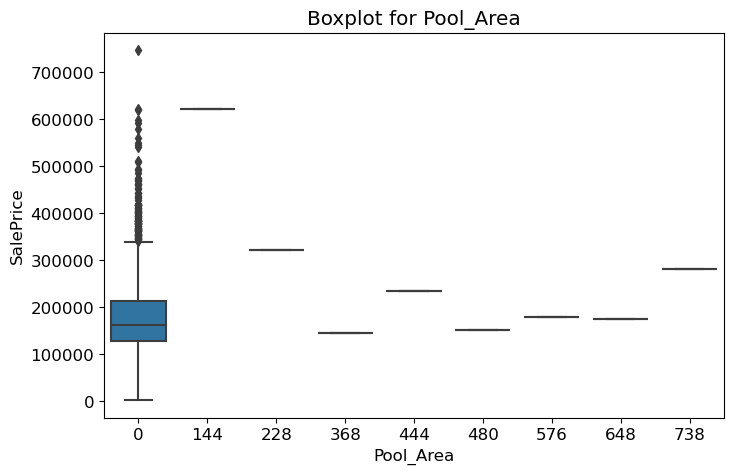

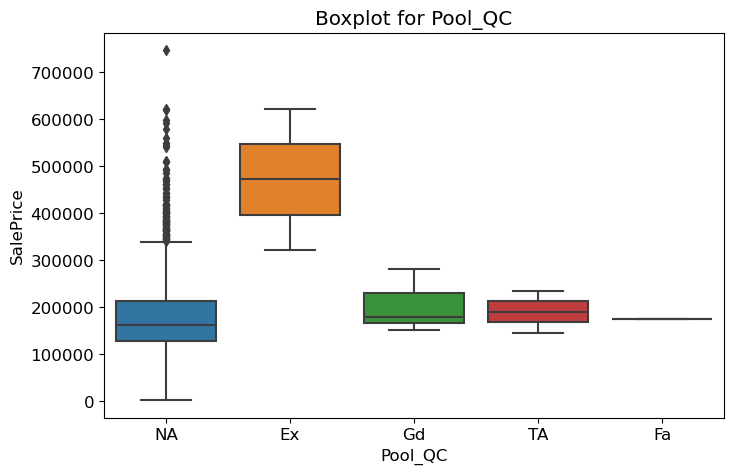

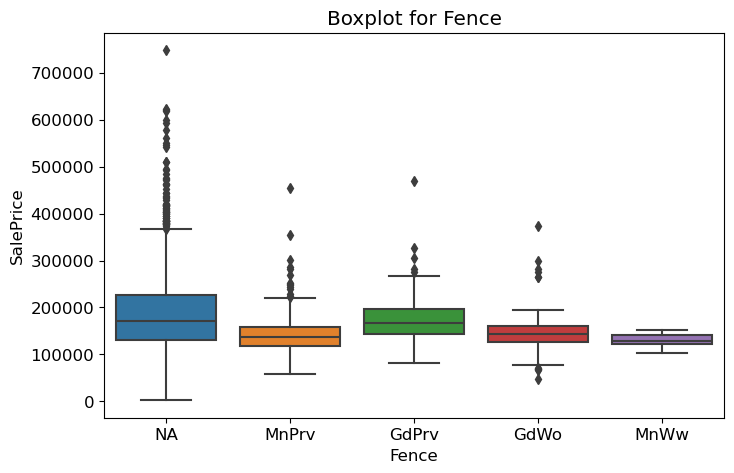

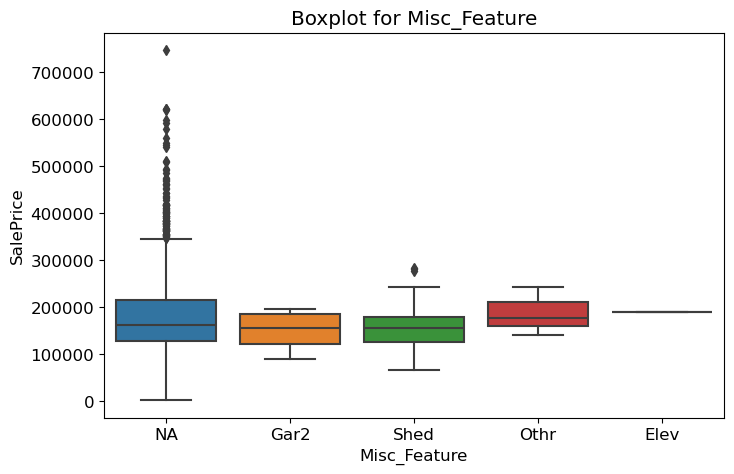

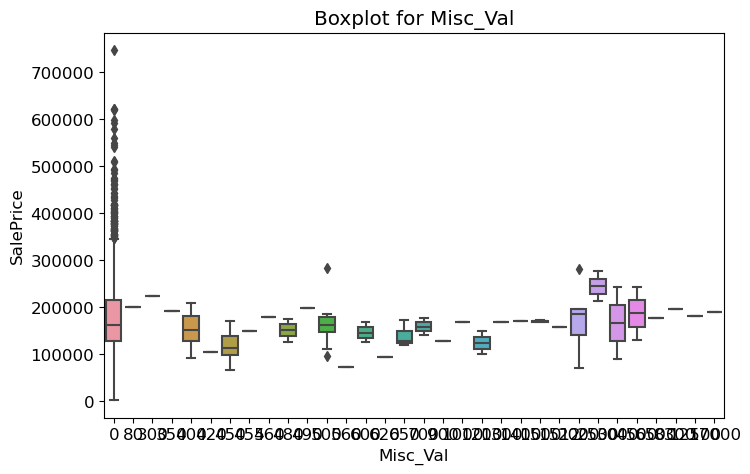

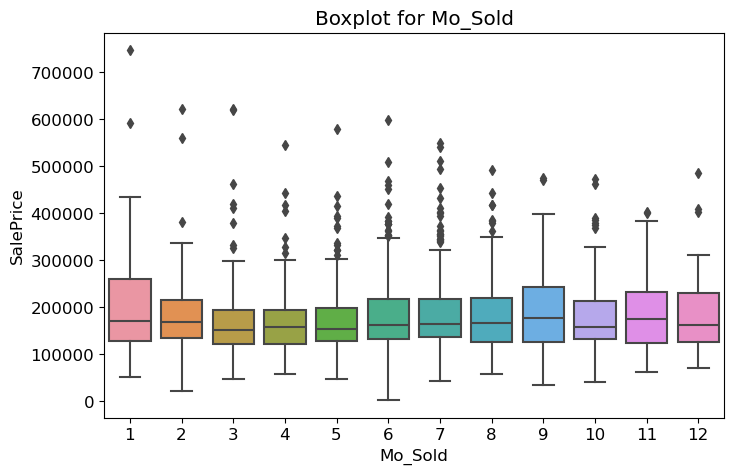

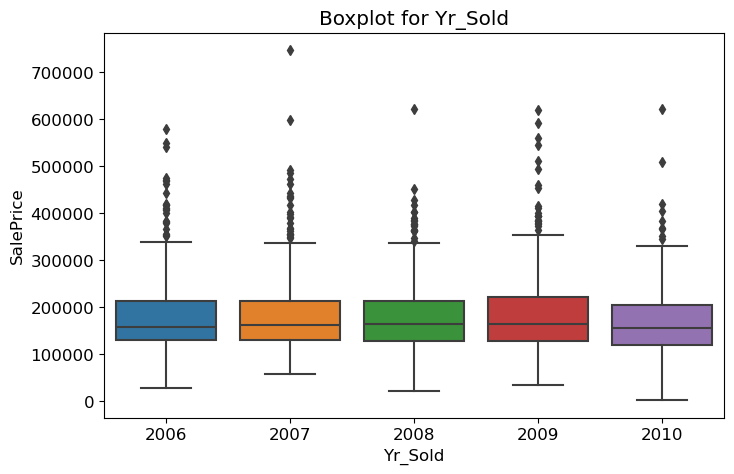

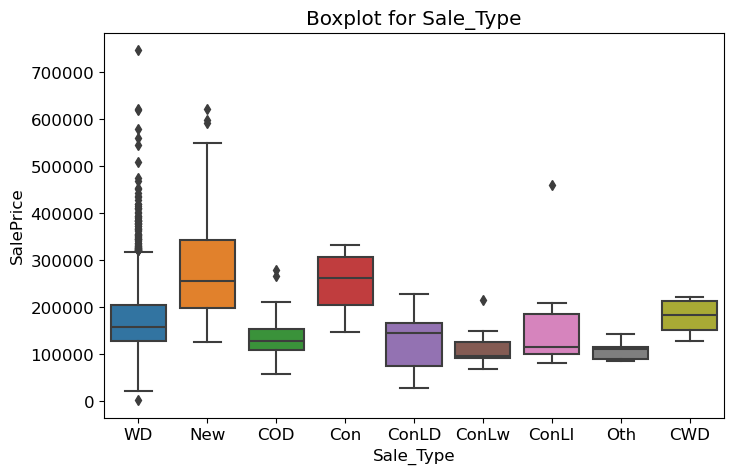

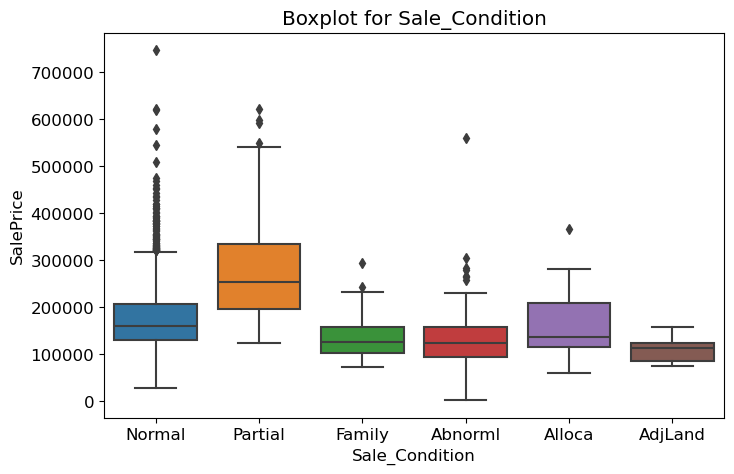

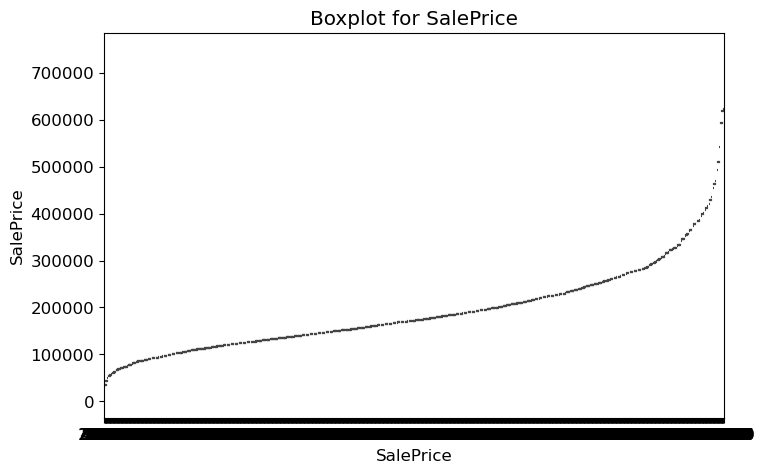

In [244]:
plot_price_var_boxplot(training_data)

In [ ]:
Year_Remod_df = pd.DataFrame(training_data.groupby('Year_Remod/Add')['SalePrice'].mean()).reset_index()

sns.barplot(data = training_data, x = 'Year_Remod/Add', y = 'SalePrice')
plt.xticks(rotation = 90)
plt.title('Mean Sale Price Distributed per Year Property was Remodeled')
plt.xlabel('Year Remodeled')
plt.ylabel('Sale Price (USD)')

In [245]:
def group_MS_Zoning(dataframe): # intuition here is that residential area is more desirable than the rest
    replacement_dict = {
                        'RL' : 'res_low',
                        'RH' : 'res_high',
                        'RM' : 'res_medium',
                        'RP' : 'res_park',
                        'FV' : 'floating_village',
                        'I' : 'commercial',
                        'C' : 'industrial',
                        'A' : 'agriculture'
                        }

    dataframe['MS_Zoning'] = dataframe['MS_Zoning'].replace(replacement_dict)

    cats = ['res_low', 'res_high', 'res_medium', 'res_park', 'floating_village', 'commercial', 'industrial', 'agriculture']

    cat_type = CategoricalDtype(categories=cats)

    dataframe['MS_Zoning'] = dataframe['MS_Zoning'].astype(cat_type)

    dummies = pd.get_dummies(dataframe['MS_Zoning'], prefix='zoning', drop_first=True)

    dataframe = pd.concat([dataframe, dummies], axis=1)

    dataframe.drop(['MS_Zoning'], axis=1, inplace=True)

    return dataframe

def group_Overall_Qual(dataframe): # want to group overall finish quality, might not use.
    replacement_dict = {
                        10 : 'excellent',
                        9 : 'excellent',
                        8 : 'good',
                        7 : 'good',
                        6 : 'average',
                        5 : 'average',
                        4 : 'bad',
                        3 : 'bad',
                        2 : 'very_bad',
                        1 : 'very_bad',
                        }

    dataframe['Overall_Qual'] = dataframe['Overall_Qual'].replace(replacement_dict)

    cats = ['good', 'average', 'bad']

    cat_type = CategoricalDtype(categories = cats)

    dataframe['Overall_Qual'] = dataframe['Overall_Qual'].astype(cat_type)

    dummies = pd.get_dummies(dataframe['Overall_Qual'], prefix='house_qual', drop_first=True)

    dataframe = pd.concat([dataframe, dummies], axis=1)

    dataframe.drop(['Overall_Qual'], axis=1, inplace=True)

    return dataframe

def group_Bsmt_Qual(dataframe): # check if basement or not ? maybe this is too specific
    replacement_dict = {
                        'Ex' : 'excellent',
                        'Gd' : 'good',
                        'TA' : 'typical',
                        'Fa' : 'typical',
                        'Po' : 'poor',
                        'NA' : 'none'
                        }
    
    dataframe['Bsmt_Qual'] = dataframe['Bsmt_Qual'].replace(replacement_dict)

    cats = ['excellent', 'good', 'typical', 'poor', 'none']

    cat_type = CategoricalDtype(categories = cats)

    dataframe['Bsmt_Qual'] = dataframe['Bsmt_Qual'].astype(cat_type)

    dummies = pd.get_dummies(dataframe['Bsmt_Qual'], prefix='basement', drop_first=True)

    dataframe = pd.concat([dataframe, dummies], axis=1)

    dataframe.drop(['Bsmt_Qual'], axis=1, inplace=True)

    return dataframe

def group_Exter_Qual(dataframe):
    replacement_dict = {
                        'Ex' : 'excellent',
                        'Gd' : 'good',
                        'TA' : 'average',
                        'Fa' : 'fair',
                        'Po' : 'poor'
                        }

    dataframe['Exter_Qual'] = dataframe['Exter_Qual'].replace(replacement_dict)

    cats = ['excellent', 'good', 'average', 'fair', 'poor']

    cat_type = CategoricalDtype(categories = cats)

    dataframe['Exter_Qual'] = dataframe['Exter_Qual'].astype(cat_type)

    dummies = pd.get_dummies(dataframe['Exter_Qual'], prefix='exter_quality', drop_first=True)

    dataframe = pd.concat([dataframe, dummies], axis=1)

    dataframe.drop(['Exter_Qual'], axis=1, inplace=True)

    return dataframe

def group_Functional(dataframe): # house quality, likely that salvage will influence this to some extent ? will need to finetune
    replacement_dict = {
                        'Typ' : 'good',
                        'Min1' : 'good',
                        'Min2' : 'good',
                        'Mod' : 'good',
                        'Maj1' : 'bad',
                        'Maj2' : 'bad',
                        'Sev' : 'bad',
                        'Sal' : 'bad'
                        }

    dataframe['Functional'] = dataframe['Functional'].replace(replacement_dict)

    cats = ['good', 'bad']

    cat_type = CategoricalDtype(categories = cats)

    dataframe['Functional'] = dataframe['Functional'].astype(cat_type)

    dummies = pd.get_dummies(dataframe['Functional'], prefix='functional', drop_first=True)

    dataframe = pd.concat([dataframe, dummies], axis=1)

    dataframe.drop(['Functional'], axis=1, inplace=True)

    return dataframe

def group_Garage_Cars(dataframe): # having a garage should increase the value of the property
    replacement_dict = {
                        1 : 'small',
                        2 : 'small',
                        3 : 'average',
                        4 : 'big',
                        5 : 'big',
                        'NA' : 'none'
                        }

    dataframe['Garage_Cars'] = dataframe['Garage_Cars'].replace(replacement_dict)

    cats = ['good', 'average', 'bad', 'poor']

    cat_type = CategoricalDtype(categories = cats)

    dataframe['Garage_Cars'] = dataframe['Garage_Cars'].astype(cat_type)

    dummies = pd.get_dummies(dataframe['Garage_Cars'], prefix='garage_size', drop_first=True)

    dataframe = pd.concat([dataframe, dummies], axis=1)

    dataframe.drop(['Garage_Cars'], axis=1, inplace=True)

    return dataframe

def group_Pool_QC(dataframe) : # maybe having a pool could increase value of house ?
    replacement_dict = {
                        'Ex' : 'yes',
                        'Gd' : 'yes',
                        'TA' : 'yes',
                        'NA' : 'no'
                        }

    dataframe['Pool_QC'] = dataframe['Pool_QC'].replace(replacement_dict)

    cats = ['yes', 'no']

    cat_type = CategoricalDtype(categories = cats)

    dataframe['Pool_QC'] = dataframe['Pool_QC'].astype(cat_type)

    dummies = pd.get_dummies(dataframe['Pool_QC'], prefix='pool', drop_first=True)

    dataframe = pd.concat([dataframe, dummies], axis=1)

    dataframe.drop(['Pool_QC'], axis=1, inplace=True)

    return dataframe

def group_Central_Air(dataframe):
    replacement_dict = {
                        'Y' : 'yes',
                        'N' : 'no'
                        }
    
    dataframe['Central_Air'] = dataframe['Central_Air'].replace(replacement_dict)

    cats = ['yes', 'no']

    cat_type = CategoricalDtype(categories = cats)

    dataframe['Central_Air'] = dataframe['Central_Air'].astype(cat_type)

    dummies = pd.get_dummies(dataframe['Central_Air'], prefix='central_air', drop_first=True)

    dataframe = pd.concat([dataframe, dummies], axis=1)

    dataframe.drop(['Central_Air'], axis=1, inplace=True)

    return dataframe

def group_Full_Bath(dataframe):
    replacement_dict = {
                        0 : 'zero',
                        1 : 'one',
                        2 : 'two',
                        3 : 'three',
                        4 : 'four'
                        }
    
    dataframe['Full_Bath'] = dataframe['Full_Bath'].replace(replacement_dict)

    cats = ['zero', 'one', 'two', 'three', 'four']

    cat_type = CategoricalDtype(categories = cats)

    dataframe['Full_Bath'] = dataframe['Full_Bath'].astype(cat_type)

    dummies = pd.get_dummies(dataframe['Full_Bath'], prefix='bathrooms_full', drop_first=True)

    dataframe = pd.concat([dataframe, dummies], axis=1)

    dataframe.drop(['Full_Bath'], axis=1, inplace=True)

    return dataframe

def group_Fireplace_Qu(dataframe):
    replacement_dict = {
                        'Ex' : 'excellent',
                        'Gd' : 'good',
                        'TA' : 'good',
                        'Fa' : 'good',
                        'Po' : 'good',
                        'NA' : 'none'
                        }

    dataframe['Fireplace_Qu'] = dataframe['Fireplace_Qu'].replace(replacement_dict)

    cats = ['excellent', 'good', 'none']

    cat_type = CategoricalDtype(categories = cats)

    dataframe['Fireplace_Qu'] = dataframe['Fireplace_Qu'].astype(cat_type)

    dummies = pd.get_dummies(dataframe['Fireplace_Qu'], prefix='fireplace_quality', drop_first=True)

    dataframe = pd.concat([dataframe, dummies], axis=1)

    dataframe.drop(['Fireplace_Qu'], axis=1, inplace=True)

    return dataframe

def group_TotRms_AbvGd(dataframe): # not use this one, maybe later
    replacement_dict = {
                        1 : 'not_many',
                        2 : 'not_many',
                        3 : 'not_many',
                        4 : 'not_many',
                        5 : 'average',
                        6 : 'average',
                        7 : 'average',
                        8 : 'lots',
                        9 : 'lots',
                        10 : 'lots',
                        11 : 'lots',
                        12 : 'lots',
                        }

    dataframe['TotRms_AbvGd'] = dataframe['TotRms_AbvGd'].replace(replacement_dict)

    cats = ['not_many', 'average', 'lots']

    cat_type = CategoricalDtype(categories = cats)

    dataframe['TotRms_AbvGd'] = dataframe['TotRms_AbvGd'].astype(cat_type)

    dummies = pd.get_dummies(dataframe['TotRms_AbvGd'], prefix='rooms_abvg', drop_first=True)

    dataframe = pd.concat([dataframe, dummies], axis=1)

    dataframe.drop(['TotRms_AbvGd'], axis=1, inplace=True)

    return dataframe

In [323]:
def group_remodel_year(dataframe):
    dataframe['remodel_year'] = pd.cut(dataframe['Year_Remod/Add'], 
                            bins=[1950, 1968, 1983, 1992, 2005, 2010], 
                            labels=['1950-1968', '1969-1983', '1983-1992', '1992-2005', '2006-2010'], 
                            right=False)
    
    dummies = pd.get_dummies(dataframe['remodel_year'], prefix='remodel_year', drop_first=True)

    dataframe = pd.concat([dataframe, dummies], axis=1)

    dataframe.drop(['remodel_year'], axis=1, inplace=True)
    
    return dataframe

In [246]:
def standardize_columns(data):
    standardized_data = (data - np.mean(data)) / np.std(data) # z score

    return standardized_data

In [247]:
# making a ground breaking new feature -> lot size / living area

def garden_house_ratio(dataframe):
    dataframe['g_h_ratio'] = dataframe['Lot_Area'] / dataframe['Gr_Liv_Area']

    return dataframe

In [250]:
def group_Neighborhood(dataframe): # will revise the grouping of this variable later, working prototype
    replacement_dict = {
                        'StoneBr' : 'rich',
                        'NridgHt' : 'rich',
                        'NoRidge' : 'rich',
                        'GrnHill' : 'rich',
                        'Veenker' : 'moderate',
                        'Timber'  : 'moderate',
                        'Somerst' : 'moderate',
                        'Greens'  : 'moderate',
                        'CollgCr' : 'moderate',
                        'Crawfor' : 'moderate',
                        'Blmngtn' : 'moderate',
                        'ClearCr' : 'moderate',
                        'NWAmes'  : 'moderate',
                        'Gilbert' : 'moderate',
                        'SawyerW' : 'moderate',
                        'Mitchel' : 'moderate',
                        'NPkVill' : 'moderate',
                        'NAmes'   : 'poor',
                        'Sawyer'  : 'poor',
                        'SWISU'   : 'poor',
                        'Edwards' : 'poor',
                        'Blueste' : 'poor',
                        'BrkSide' : 'poor',
                        'OldTown' : 'poor',
                        'BrDale'  : 'poor',
                        'IDOTRR'  : 'poor',
                        'MeadowV' : 'poor'
                        }

    dataframe['Neighborhood'] = dataframe['Neighborhood'].replace(replacement_dict)

    cats = ['rich', 'moderate', 'poor']

    cat_type = CategoricalDtype(categories = cats)

    dataframe['Neighborhood'] = dataframe['Neighborhood'].astype(cat_type)

    dummies = pd.get_dummies(dataframe['Neighborhood'], prefix='neighborhood', drop_first=True)

    dataframe = pd.concat([dataframe, dummies], axis=1)

    dataframe.drop(['Neighborhood'], axis=1, inplace=True)

    return dataframe

In [251]:
def richest_neighborhoods(dataframe):
    rich_countries = dataframe.groupby('Neighborhood')['SalePrice'].median().sort_values(ascending = False)
    return rich_countries

In [252]:
def check_duplicates(dataframe): # no duplicates, good
    dupes = dataframe[dataframe.duplicated()]

    return dupes

check_duplicates(training_data)

Empty DataFrame
Columns: [Order, PID, MS_SubClass, MS_Zoning, Lot_Frontage, Lot_Area, Street, Alley, Lot_Shape, Land_Contour, Utilities, Lot_Config, Land_Slope, Neighborhood, Condition_1, Condition_2, Bldg_Type, House_Style, Overall_Qual, Overall_Cond, Year_Built, Year_Remod/Add, Roof_Style, Roof_Matl, Exterior_1st, Exterior_2nd, Mas_Vnr_Type, Mas_Vnr_Area, Exter_Qual, Exter_Cond, Foundation, Bsmt_Qual, Bsmt_Cond, Bsmt_Exposure, BsmtFin_Type_1, BsmtFin_SF_1, BsmtFin_Type_2, BsmtFin_SF_2, Bsmt_Unf_SF, Total_Bsmt_SF, Heating, Heating_QC, Central_Air, Electrical, 1st_Flr_SF, 2nd_Flr_SF, Low_Qual_Fin_SF, Gr_Liv_Area, Bsmt_Full_Bath, Bsmt_Half_Bath, Full_Bath, Half_Bath, Bedroom_AbvGr, Kitchen_AbvGr, Kitchen_Qual, TotRms_AbvGrd, Functional, Fireplaces, Fireplace_Qu, Garage_Type, Garage_Yr_Blt, Garage_Finish, Garage_Cars, Garage_Area, Garage_Qual, Garage_Cond, Paved_Drive, Wood_Deck_SF, Open_Porch_SF, Enclosed_Porch, 3Ssn_Porch, Screen_Porch, Pool_Area, Pool_QC, Fence, Misc_Feature, Misc_Val, Mo_Sold, Yr_Sold, Sale_Type, Sale_Condition, SalePrice, g_h_ratio]
Index: []

[0 rows x 83 columns]

In [326]:
def create_dummies(dataframe): # creates dummies for each column
    dataframe = group_Bsmt_Qual(dataframe)
    dataframe = group_Central_Air(dataframe)
    dataframe = group_Exter_Qual(dataframe)
    dataframe = group_Fireplace_Qu(dataframe)
    dataframe = group_Full_Bath(dataframe)
    dataframe = group_Functional(dataframe)
    dataframe = group_Garage_Cars(dataframe)
    dataframe = group_MS_Zoning(dataframe)
    dataframe = group_Neighborhood(dataframe)
    dataframe = group_Overall_Qual(dataframe)
    dataframe = group_Pool_QC(dataframe)
    dataframe = group_remodel_year(dataframe)

    return dataframe

In [261]:
def rmse(actual, predicted):
    rmse = np.sqrt(np.mean((np.array(actual) - np.array(predicted)) ** 2))

    return rmse

In [327]:
# apologies for not using the whole pipeline thing, this just works

def process_data_fm(data):
    # Clean Data
    data = remove_outliers(data, ['SalePrice'], 3)
    data = drop_columns_missing_values(data, 200, ['Lot_Frontage'])
    data = replace_wrong_NA(data, ['Order', 'PID'])

    # Transform Data
    data = garden_house_ratio(data) # create new ground breaking feature
    data = create_dummies(data) # create all the dummies for the model

    # More?
    y = data['SalePrice']
    X = data.drop(['SalePrice'], axis = 1)
    X = X.loc[:, 'g_h_ratio':]
    standardize_columns(X['g_h_ratio'])

    return X, y

In [328]:
training_data = pd.read_csv("ames_train.csv")
test_data = pd.read_csv("ames_test.csv")

In [329]:
# Process the data
X_train, y_train = process_data_fm(training_data)
X_test, y_test = process_data_fm(test_data)

/var/folders/28/nqw3v6ld39g_jrhl3y66nq2w0000gn/T/ipykernel_794/1729318459.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'NA' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  dataframe[column].fillna("NA", inplace=True)
/var/folders/28/nqw3v6ld39g_jrhl3y66nq2w0000gn/T/ipykernel_794/1729318459.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'NA' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  dataframe[column].fillna("NA", inplace=True)


In [330]:
# using the same code written above in item 2. 
# i use lasso, ridge does not converge with my model 

# Process the data
X_train, y_train = process_data_fm(training_data)
X_test, y_test = process_data_fm(test_data)

# Specify the model, alphas, and number of folds for CV
alphas = np.arange(0.1, 200.1, .1)
lassoModel = lm.LassoCV(alphas = alphas, cv = 5)

# Fit and predict
lassoModel.fit(X_train, y_train)
y_predicted = lassoModel.predict(X_test)

print(f'The validation RMSE for this model with '
      f'alpha={round(float(guidedmodel2.alpha_), 2)} is '
      f'{round(rmse(y_test, y_predicted), 2)}.')

/var/folders/28/nqw3v6ld39g_jrhl3y66nq2w0000gn/T/ipykernel_794/1729318459.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'NA' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  dataframe[column].fillna("NA", inplace=True)
/var/folders/28/nqw3v6ld39g_jrhl3y66nq2w0000gn/T/ipykernel_794/1729318459.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'NA' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  dataframe[column].fillna("NA", inplace=True)


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


The residual plot shows a slight upwards trend, and a small increase in variance as the sale price increases, which is to be expected given the fact that we simply have less data sets for more expensive properties. 

Text(0, 0.5, 'Residuals (Actual Price - Predicted Price)')

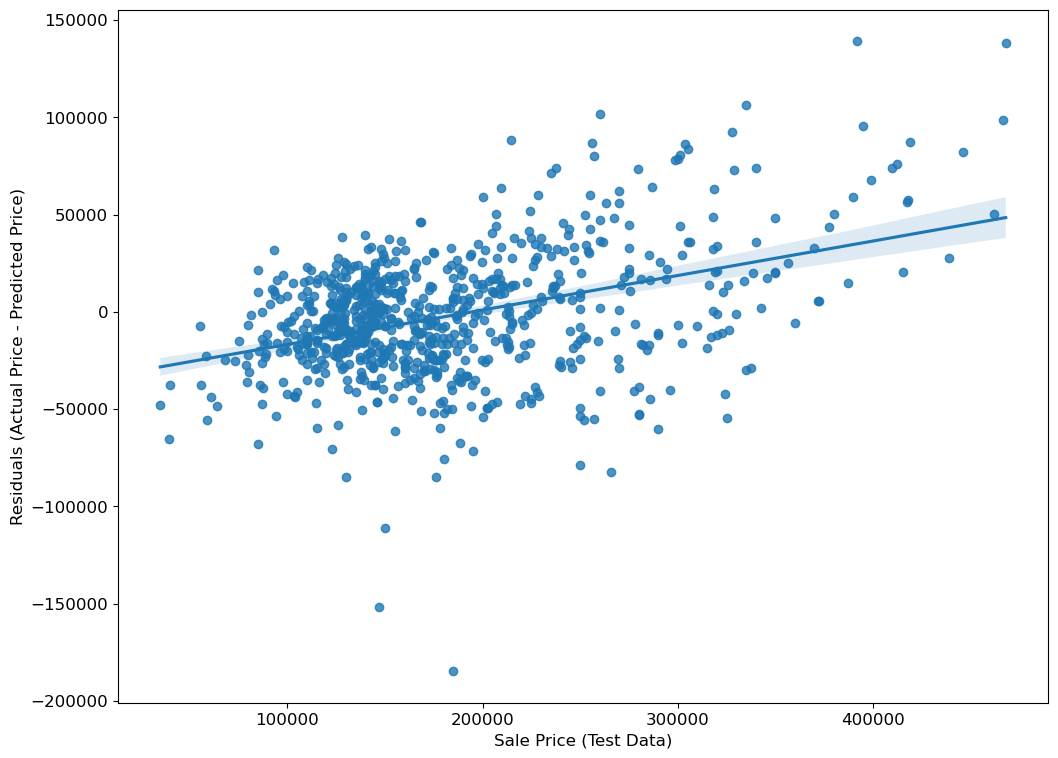

In [331]:
fm_residuals = y_test - y_predicted
ax = sns.regplot(x=y_test, y=fm_residuals)
ax.set_xlabel('Sale Price (Test Data)')
ax.set_ylabel('Residuals (Actual Price - Predicted Price)')

In [332]:
alphas = np.arange(0.1, 200.1, .1)
final_model = lm.LassoCV(alphas=alphas, cv=5)

I find alpha = 59.7
RMSE = 31646.85

overall a decent improvement from the "showcase" model in part 2

In [333]:
training_data = pd.read_csv('ames_train.csv')
X_train, y_train = process_data_fm(training_data)
final_model.fit(X_train, y_train)

/var/folders/28/nqw3v6ld39g_jrhl3y66nq2w0000gn/T/ipykernel_794/1729318459.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'NA' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  dataframe[column].fillna("NA", inplace=True)


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


LassoCV(alphas=array([1.000e-01, 2.000e-01, 3.000e-01, ..., 1.998e+02, 1.999e+02,
       2.000e+02]),
        cv=5)

In [334]:
##keep these for now. we will use this to check your models

#training_data = pd.read_csv('ames_train.csv')
#public_test_data = pd.read_csv('ames_test.csv')
#public_test_data = pd.read_csv('public_test_set.csv')
#private_test_data = pd.read_csv('private_test_set.csv')

#X_train, y_train = process_data_fm(training_data)
#X_public, y_public = process_data_fm(public_test_data)
#X_private, y_private = process_data_fm(private_test_data)

#final_model.fit(X_train, y_train)
#y_predicted_train = final_model.predict(X_train)
#y_predicted_public = final_model.predict(X_public)
#y_predicted_private = final_model.predict(X_private)

#training_score = rmse(y_predicted_train, y_train)
#public_score = rmse(y_predicted_public, y_public)
#private_score = rmse(y_predicted_private, y_private)

# 4. The aftermath

The following questions are supposed to be answered after you have completed your model submission and they are supposed to be used as reflection of the whole modeling process.

#### Question 4<a name="q4"></a>

In addition, please submit one visualization from your EDA with 2-5 sentences describing why you thought the plot was interesting and what decisions it led to in your model specification.

Text(0, 0.5, 'Sale Price (USD)')

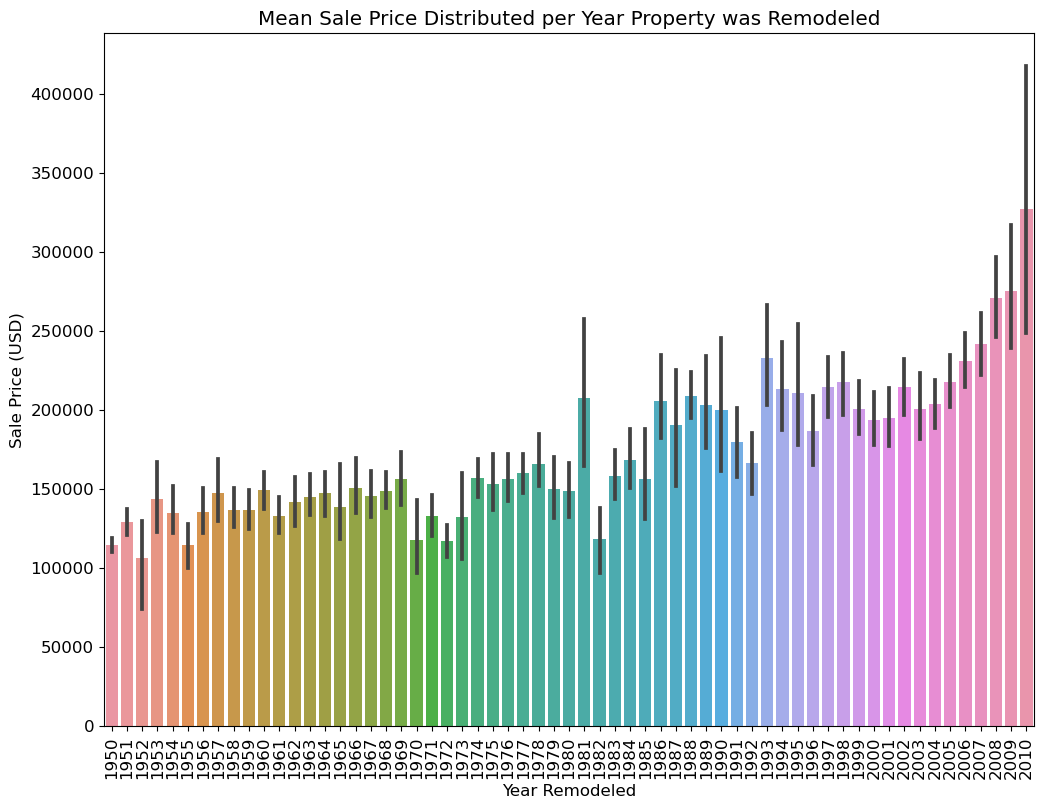

In [298]:
Year_Remod_df = pd.DataFrame(training_data.groupby('Year_Remod/Add')['SalePrice'].mean()).reset_index()

sns.barplot(data = training_data, x = 'Year_Remod/Add', y = 'SalePrice')
plt.xticks(rotation = 90)
plt.title('Mean Sale Price Distributed per Year Property was Remodeled')
plt.xlabel('Year Remodeled')
plt.ylabel('Sale Price (USD)')

**ANSWER**

As you can see on the plot I provided above, mean sale price is correlated to how recent a house was remodeled (or built if no remodel). We can see quite a strong increase in sale price as the properties get more recent. This should definitely not be ignored.

What this led me to do is incorportate it in my model, to do so I have just separated the houses in 5 categories; 

-> 1950 - 1968

-> 1969 - 1983

-> 1984 - 1992

-> 1993 - 2005

-> 2005 - 2010

this may not be perfect and very precise but I hope to have captured the effect of this variable on sale price!

#### Question 5 <a name="q5"></a>


Name a feature that isn't listed in this dataset but may be useful for predicting sales values. What insights could this feature provide? How might it increase or decrease a home’s sales value?

**ANSWER**

I would have to say some indicator about the quality of the nearest schools would help a lot in determining house prices. After all, it is normal to expect that houses which are very close to good schools would typically sell for more than houses either far away or close to mediocre schools. Now this would only affect families valuation of houses, but we saw in this dataset that single family houses were the most common entry in the dataset, so this would be a good variable to have, in my opinion.

#### Question 6 <a name="q6"></a>

When evaluating your model, we used root mean squared error. Of course, in the context of our machine learning models that is great. However, In the context of estimating the value of houses, what does error mean for an individual homeowner? How does it affect them in terms of property taxes?

In the case of the Cook County Assessor’s Office, Chief Data Officer Rob Ross states that fair property tax rates are contingent on whether property values are assessed accurately - that they’re valued at what they’re worth, relative to properties with similar characteristics. This implies that having a more accurate model results in fairer assessments. The goal of the property assessment process for the CCAO, then, is to be as accurate as possible.

When the use of algorithms and statistical modeling has real-world consequences, we often refer to the idea of fairness as a measurement of how socially responsible our work is. But fairness is incredibly multifaceted: Is a fair model one that minimizes loss - one that generates accurate results? Is it one that utilizes "unbiased" data? Or is fairness a broader goal that takes historical contexts into account?

These approaches to fairness are not mutually exclusive. If we look beyond error functions and technical measures of accuracy, we'd not only consider individual cases of fairness, but also what fairness - and justice - means to marginalized communities on a broader scale. We'd ask: What does it mean when homes in predominantly Black and Hispanic communities in Cook County are consistently overvalued, resulting in proportionally higher property taxes? When the white neighborhoods in Cook County are consistently undervalued, resulting in proportionally lower property taxes?

Having "accurate" predictions doesn't necessarily address larger historical trends and inequities, and fairness in property assessments in taxes works beyond the CCAO's valuation model. Disassociating accurate predictions from a fair system is vital to approaching justice at multiple levels. Take Evanston, IL - a suburb in Cook County - as an example of housing equity beyond just improving a property valuation model: Their City Council members [recently approved reparations for African American residents](https://www.usnews.com/news/health-news/articles/2021-03-23/chicago-suburb-approves-government-reparations-for-black-residents).

As a final question to this (hopefully eye opening clinic), describe (in your own words) how you would define fairness in property assessments and taxes.

**ANSWER**

For individual homeowners, model error can either lead us to overestimate or underestimate the value of houses. Of course, if our model consistantly overvalues cheap houses, then those people will end up paying higher property taxes, and vice versa. It creates a divide. 

In my opinion, while historical context does have a part in determining whether our model is fair or not, if we are to take house prices in this current day into consideration for our model, then the most fair model should be one which is unbiased. Yes, different parties may not be pleased with the market, but it is more important to be unbiased than to overinflate some houses' price and vice-versa. I would not include any factor which would influence house prices based on what community the owner identifies with, but rather only look at people's financial situation individually.

Consistent overvaluation of black and hispanic houses perpetrates historical disparities between those communities and white communities. Furthermore, it also imposes an important tax burden on people who are unlikely to be able to afford their houses in the first place. 

I believe fairness starts with an accurate valuation of house prices for all neighborhoods. What is also important to take into account is the financial situation of the people in different neighborhoods. This would avoid taking ethnicity into account and creating further bias in valuation, but would instead make sure houses are valued independently of their owner. This is a fair treatment in terms of valuation, and therefore in terms of taxes.